In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from src.interest_rate_models.semilog_irm import SemiLogIRM
from src.interest_rate_models.p_controller_irm import PControllerIRM
from src.calibration import calibrate_w_model
from src.metrics import calculate_metrics, composite_objective
from src.validation import validate_optimized_irm
from src.simulation import simulate_utilization_paths
from src.curve_lending_data_loader import CurveLendingMarketDataLoader

### Step 1: Load and Prepare Data


In [66]:
loader = CurveLendingMarketDataLoader(chain='ethereum', controller_address='0xeda215b7666936ded834f76f3fbc6f323295110a')
df = loader.retrieve_data()
df = loader.enrich_data(df)

### Step 2: Estimate W Model Parameters

In [67]:

parameters, model_summary = calibrate_w_model(df)

print(model_summary)

alpha, rho, b1, sigma = parameters
print("Estimated W model parameters:")
print(f"alpha = {alpha}")
print(f"rho = {rho}")
print(f"b1 = {b1}")
print(f"sigma = {sigma}")

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     574.5
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           6.37e-99
Time:                        10:43:52   Log-Likelihood:                -30.088
No. Observations:                 278   AIC:                             66.18
Df Residuals:                     275   BIC:                             77.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0544      0.024      2.303      0.0

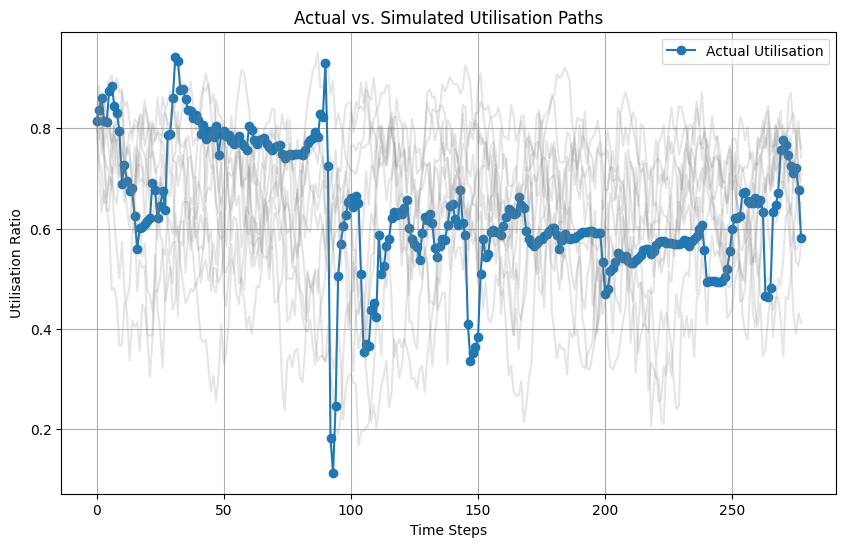

In [68]:
# Initialize IRMs
rate_model_semilog = SemiLogIRM(rate_min=0.0001, rate_max=10)
# rate_model_p = PControllerIRM(phi_low=0.9, phi_high=1.1, threshold=0.05, target_u=0.9)


# Step 4: Simulate Synthetic Paths with Semi-Log IRM
num_steps = len(df)
W0 = df['W'].iloc[0]
num_paths = 1000

sim_paths = simulate_utilization_paths(
    alpha=alpha,
    rho=rho,
    b1=b1,
    sigma=sigma,
    W0=W0,
    num_steps=num_steps,
    num_paths=num_paths,
    controller_type=rate_model_semilog
)

# # Convert W to U
# inv_logit = lambda w: 1 / (1 + np.exp(-w))
# sim_U_paths_semilog = inv_logit(sim_U_paths_semilog)

# Plot average simulated U vs empirical U
# avg_sim_U_semilog = sim_U_paths_semilog.mean(axis=0)
emp_util = df['utilisation_ratio'].values

# Paths Comparison
plt.figure(figsize=(10,6))
plt.plot(range(num_steps), emp_util, label='Actual Utilisation', marker='o')
# plt.plot(range(num_steps), avg_sim_path, label='Average Simulated Utilisation', linestyle='--')
for i in range(min(num_paths, 10)):
    plt.plot(range(num_steps), sim_paths[i,:], color='gray', alpha=0.2)
plt.xlabel('Time Steps')
plt.ylabel('Utilisation Ratio')
plt.title('Actual vs. Simulated Utilisation Paths')
plt.legend()
plt.grid(True)
plt.show()


Empirical metrics:
Mean: 0.6362483556271259
Std Dev: 0.12557880424762738
Skewness: -0.29574579105303833
Kurtosis: 1.096634252261559

Averaged Simulated Metrics (across all paths):
Mean: 0.6347879207400385
Std Dev: 0.13322578701228768
Skewness: -0.45093465780553926
Kurtosis: -0.2873600249200336


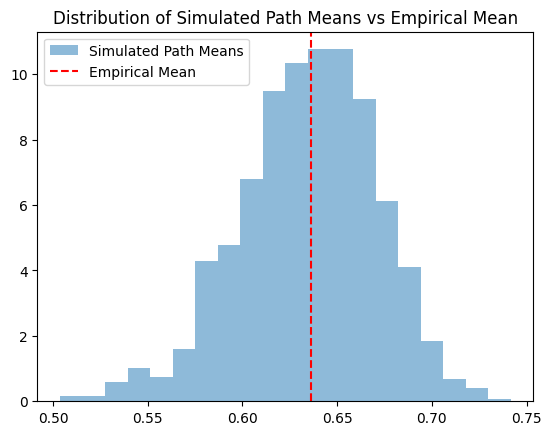

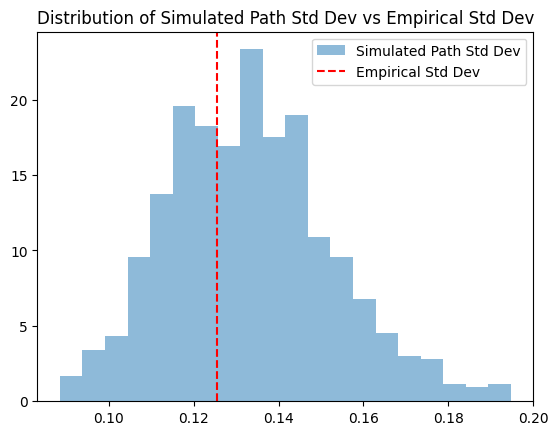

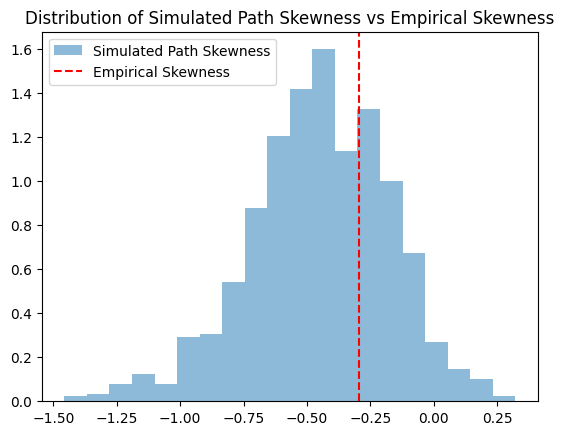

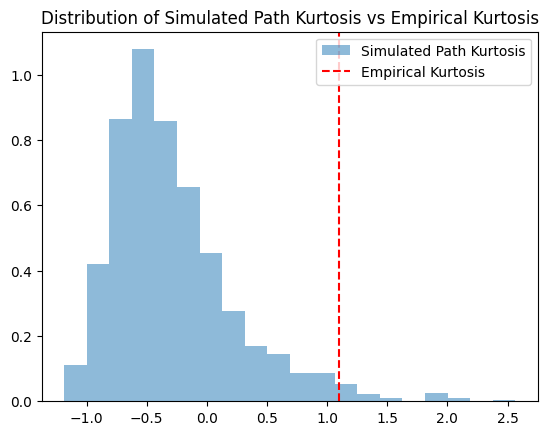

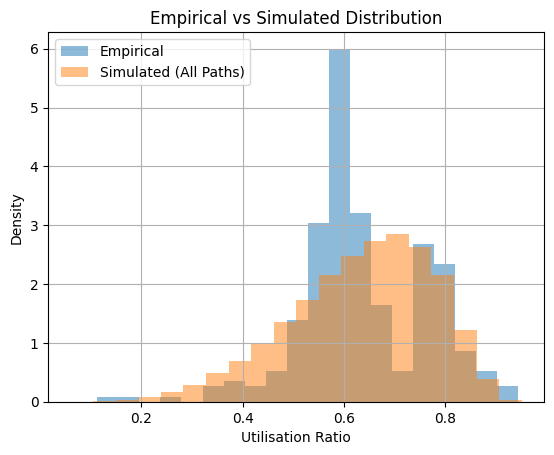

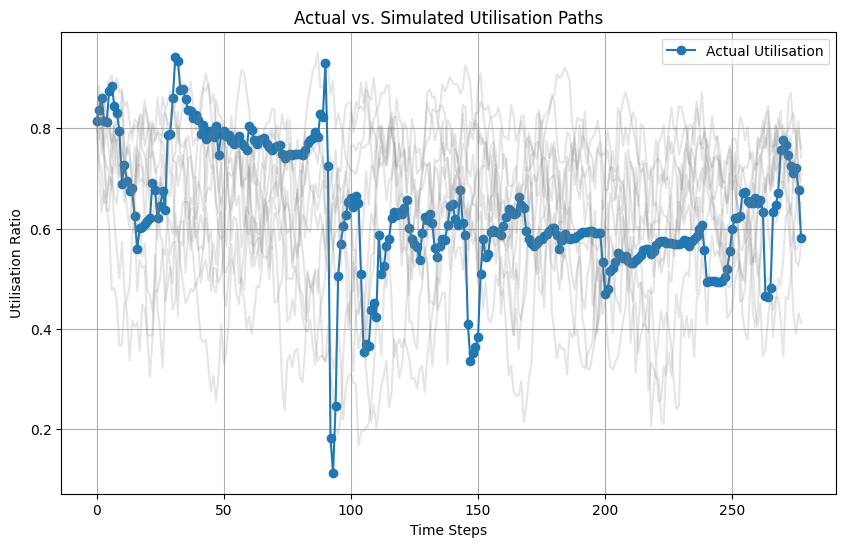

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson

# Compute empirical metrics
emp_mean = np.mean(emp_util)
emp_std = np.std(emp_util)
emp_skew = skew(emp_util)
emp_kurt = kurtosis(emp_util)

print("Empirical metrics:")
print(f"Mean: {emp_mean}")
print(f"Std Dev: {emp_std}")
print(f"Skewness: {emp_skew}")
print(f"Kurtosis: {emp_kurt}")

# Compute metrics for each simulated path
num_paths = sim_paths.shape[0]
sim_means = np.zeros(num_paths)
sim_stds = np.zeros(num_paths)
sim_skews = np.zeros(num_paths)
sim_kurts = np.zeros(num_paths)

for i in range(num_paths):
    path = sim_paths[i, :]
    sim_means[i] = np.mean(path)
    sim_stds[i] = np.std(path)
    sim_skews[i] = skew(path)
    sim_kurts[i] = kurtosis(path)

# Average metrics across all simulated paths
avg_mean = np.mean(sim_means)
avg_std = np.mean(sim_stds)
avg_skew = np.mean(sim_skews)
avg_kurt = np.mean(sim_kurts)

print("\nAveraged Simulated Metrics (across all paths):")
print(f"Mean: {avg_mean}")
print(f"Std Dev: {avg_std}")
print(f"Skewness: {avg_skew}")
print(f"Kurtosis: {avg_kurt}")

########################################
# Compare empirical distribution with the distribution of path-level metrics
########################################

# One approach is to check how the distribution of metrics from simulated paths
# compares to the empirical metric. For example, you can visualize the distribution
# of means from all simulated paths and see if the empirical mean falls near the center.

plt.hist(sim_means, bins=20, alpha=0.5, density=True, label='Simulated Path Means')
plt.axvline(emp_mean, color='red', linestyle='--', label='Empirical Mean')
plt.title("Distribution of Simulated Path Means vs Empirical Mean")
plt.legend()
plt.show()

# Similarly, do the same for std, skewness, and kurtosis
plt.hist(sim_stds, bins=20, alpha=0.5, density=True, label='Simulated Path Std Dev')
plt.axvline(emp_std, color='red', linestyle='--', label='Empirical Std Dev')
plt.title("Distribution of Simulated Path Std Dev vs Empirical Std Dev")
plt.legend()
plt.show()

plt.hist(sim_skews, bins=20, alpha=0.5, density=True, label='Simulated Path Skewness')
plt.axvline(emp_skew, color='red', linestyle='--', label='Empirical Skewness')
plt.title("Distribution of Simulated Path Skewness vs Empirical Skewness")
plt.legend()
plt.show()

plt.hist(sim_kurts, bins=20, alpha=0.5, density=True, label='Simulated Path Kurtosis')
plt.axvline(emp_kurt, color='red', linestyle='--', label='Empirical Kurtosis')
plt.title("Distribution of Simulated Path Kurtosis vs Empirical Kurtosis")
plt.legend()
plt.show()


# Flatten the simulated paths array to include all values
all_sim_values = sim_paths.flatten()

# Distribution Comparison
plt.hist(emp_util, alpha=0.5, label='Empirical', bins=20, density=True)
plt.hist(all_sim_values, alpha=0.5, label='Simulated (All Paths)', bins=20, density=True)
plt.title("Empirical vs Simulated Distribution")
plt.xlabel("Utilisation Ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


# Paths Comparison
plt.figure(figsize=(10,6))
plt.plot(range(num_steps), emp_util, label='Actual Utilisation', marker='o')
# plt.plot(range(num_steps), avg_sim_path, label='Average Simulated Utilisation', linestyle='--')
for i in range(min(num_paths, 10)):
    plt.plot(range(num_steps), sim_paths[i,:], color='gray', alpha=0.2)
plt.xlabel('Time Steps')
plt.ylabel('Utilisation Ratio')
plt.title('Actual vs. Simulated Utilisation Paths')
plt.legend()
plt.grid(True)
plt.show()



### Step 5: Optimize Semi-Log IRM Parameters


In [127]:
# Assuming the last 6 months of data for calibration
from skopt.space import Real
from src.optimization import optimize_irm_parameters

df_last6 = df.tail(180).reset_index(drop=True)

# search_space = [
#     Real(0.0001, 10, name='rate_min'),    # 0.01% to 5%
#     Real(0.0001, 10, name='delta_rate')     # 1% to 45%  # TO_DO 
# ]

search_space = [
    Real(0.0001, 10, name='rate_min'),    # rate_min between 0.0001 and 10
    Real(0.0001, 10 - 0.0001, name='delta_rate')  # delta_rate ensuring rate_max <= 10
]

def update_semilog(irm, rate_min, delta_rate):
    # Calculate rate_max
    rate_max = rate_min + delta_rate
    
    print(f"rate_min: {rate_min}||rate_max: {rate_max}")
    # Update IRM parameters
    irm.rate_min = rate_min
    irm.rate_max = rate_max

optimal_params_semilog = optimize_irm_parameters(
    df=df_last6,
    irm_class=SemiLogIRM,
    update_params= update_semilog,
    search_space=search_space,
    target_u=0.9,
    threshold_u=0.95,
    num_steps=180,
    num_paths=100,
    weights={'MSE': 1.0, 'Time_Above_Threshold': 0.5, 'Volatility_U': 0.5},
    n_calls=100,
    model_input= parameters,
    random_state=42
)


optimized_rate_min, optimized_rate_max = optimal_params_semilog.x

Iteration No: 1 started. Evaluating function at random point.
rate_min: 7.965450214303645||rate_max: 9.79986142600731
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0927
Function value obtained: 0.7730
Current minimum: 0.7730
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0005
Function value obtained: 1000000.0000
Current minimum: 0.7730
Iteration No: 3 started. Evaluating function at random point.
rate_min: 4.458382945260627||rate_max: 5.458212108457493
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0560
Function value obtained: 0.5955
Current minimum: 0.5955
Iteration No: 4 started. Evaluating function at random point.
rate_min: 4.592542994769476||rate_max: 7.929662364437467
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0641
Function value obtained: 0.6289
Current minimum: 0.5955
Iteration No: 5 started. Evaluating function at rand

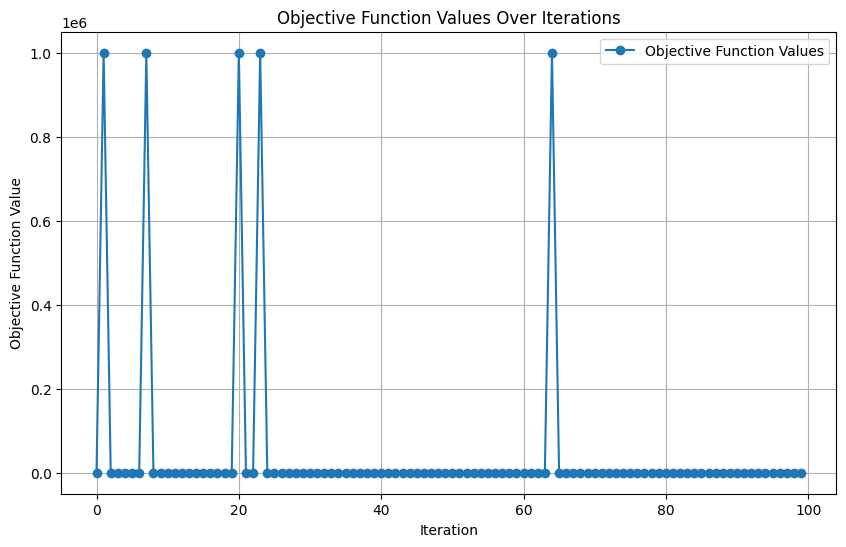

[0.0001, 9.9999]

In [129]:

# Assuming optimal_params_semilog.func_vals contains the function values
plt.figure(figsize=(10, 6))
plt.plot(optimal_params_semilog.func_vals, marker='o', linestyle='-', label='Objective Function Values')
plt.title('Objective Function Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()

optimal_params_semilog.x

In [122]:
from src.optimization import differential_evolution_optimizer

# Define bounds for rate_min and delta_rate
bounds = [(0.0001, 10), (0.0001, 10)]

def update_semilog(irm, rate_min, rate_max):
    
    # Update IRM parameters
    irm.rate_min = rate_min
    irm.rate_max = rate_max

# Example usage
result_de = differential_evolution_optimizer(
    df=df,
    irm_class=SemiLogIRM,
    bounds=bounds,
    update_params=update_semilog,
    target_u=0.9,
    threshold_u=0.95,
    num_steps=180,
    num_paths=100,
    weights={'MSE': 1.0, 'Time_Above_Threshold': 1, 'Volatility_U': 1},
    max_iter=100,
    popsize=15,
    model_input=parameters,
    seed=42
)

optimized_rate_min, optimized_rate_max = result_de.x

print(f"Optimized rate_min: {optimized_rate_min}")
print(f"Optimized rate_max: {optimized_rate_max}")

Optimized parameters: [2.39141368e-04 3.41448024e+00]
Optimized rate_min: 0.0002391413676843257
Optimized rate_max: 3.4144802406135923


In [125]:
result_de

             message: Optimization terminated successfully.
             success: True
                 fun: 0.21002989847893988
                   x: [ 2.391e-04  3.414e+00]
                 nit: 87
                nfev: 2691
          population: [[ 2.391e-04  3.414e+00]
                       [ 1.665e-04  4.749e+00]
                       ...
                       [ 2.722e-04  2.986e+00]
                       [ 3.288e-04  2.639e+00]]
 population_energies: [ 2.100e-01  2.155e-01 ...  2.128e-01  2.139e-01]

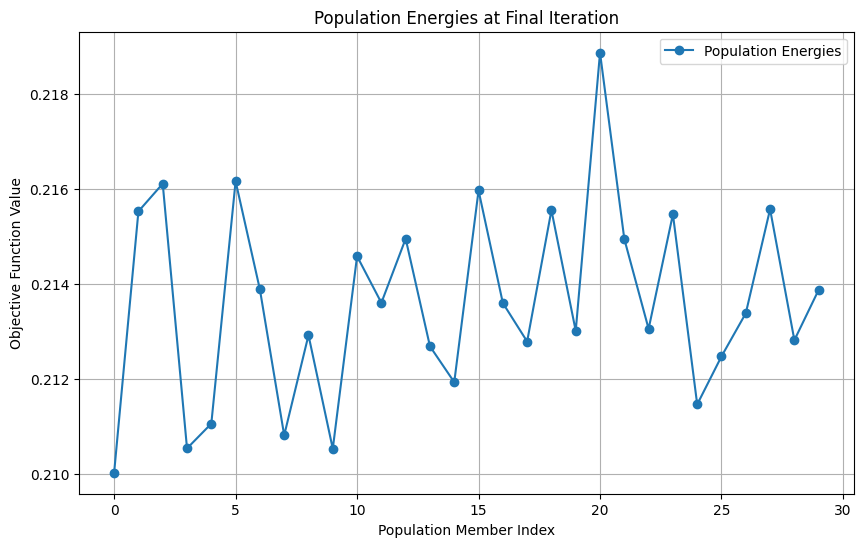

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(result_de.population_energies, marker='o', linestyle='-', label='Population Energies')
plt.title('Population Energies at Final Iteration')
plt.xlabel('Population Member Index')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()


### Step 6: Evaluate the Optimized Model



Optimized IRM Metrics Summary:
               MSE  Time_Above_Threshold  Volatility_U
count  5000.000000           5000.000000   5000.000000
mean      0.088423              0.026600      0.132156
std       0.029840              0.316089      0.022499
min       0.015984              0.000000      0.068870
25%       0.066795              0.000000      0.115863
50%       0.084571              0.000000      0.130748
75%       0.105869              0.000000      0.146739
max       0.222222             10.000000      0.220913


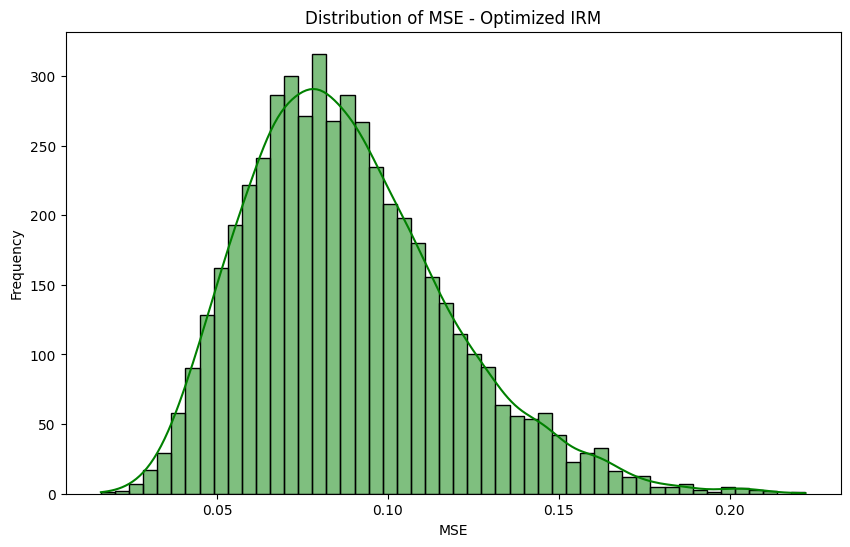

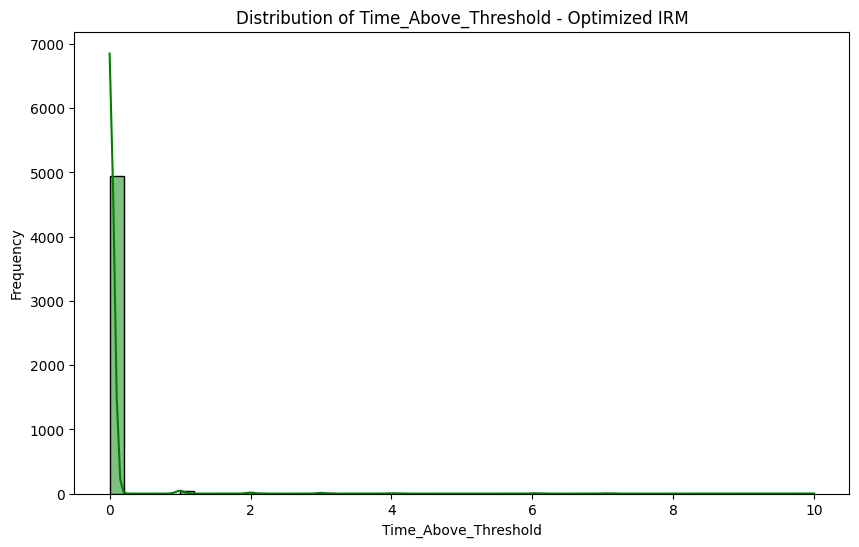

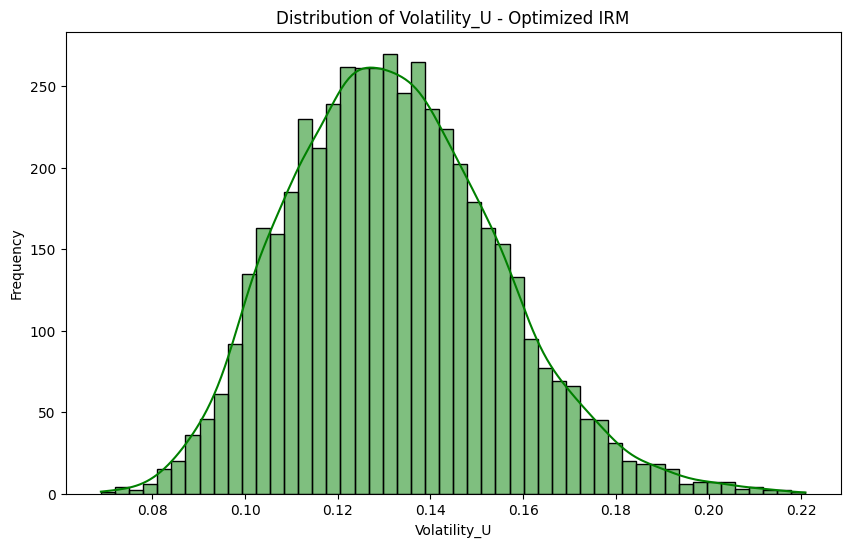

In [144]:
import seaborn as sns
metrics_df = validate_optimized_irm(
    optimized_params=result_de.x,
    df=df_last6,
    alpha=alpha,
    rho=rho,
    b1=b1,
    sigma=sigma,
    irm_class=SemiLogIRM,
    num_steps=180,
    num_paths=5000,
    target_u=0.9,
    threshold_u=0.95
)

# Summary Statistics
print("\nOptimized IRM Metrics Summary:")
print(metrics_df.describe())

# Visualizations
metrics_to_plot = ['MSE', 'Time_Above_Threshold', 'Volatility_U']
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(metrics_df[metric], bins=50, kde=True, color='green')
    plt.title(f'Distribution of {metric} - Optimized IRM')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

### Step 7: Sensitivity Analysis of rate_min and rate_max


Optimized IRM Metrics Summary:
         Rate_Min    Rate_Max         MSE  Time_Above_Threshold  Volatility_U
count  190.000000  190.000000  190.000000            190.000000    190.000000
mean     3.000100    6.500100    0.415914              0.007421      0.111991
std      2.297341    2.297341    0.199986              0.043706      0.026650
min      0.000100    0.500100    0.078317              0.000000      0.057177
25%      1.000100    5.000100    0.255141              0.000000      0.090613
50%      2.500100    7.000100    0.409770              0.000000      0.118749
75%      4.500100    8.500100    0.587501              0.000000      0.134328
max      9.000100    9.500100    0.769422              0.510000      0.154416


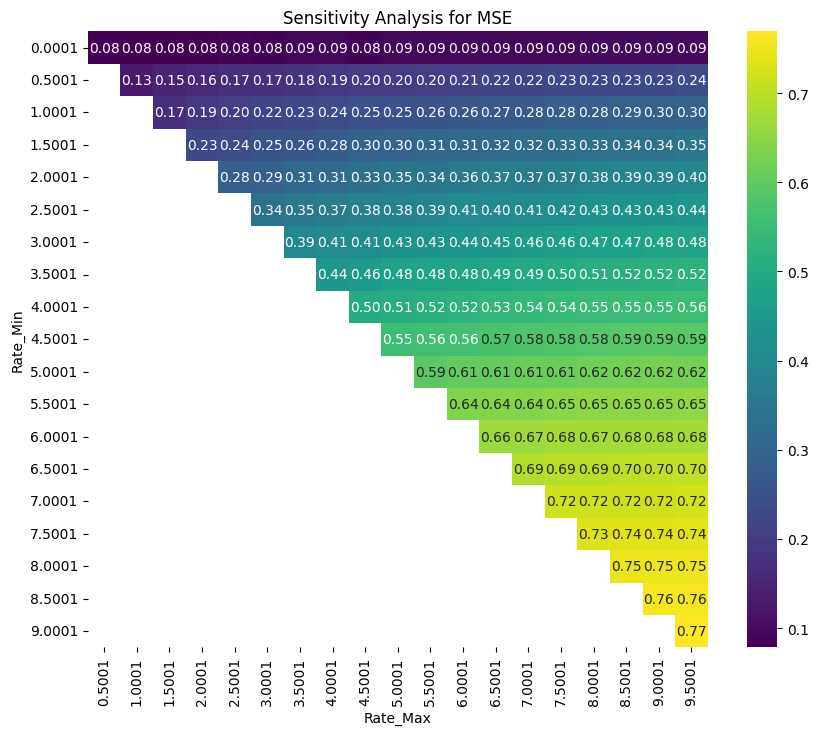

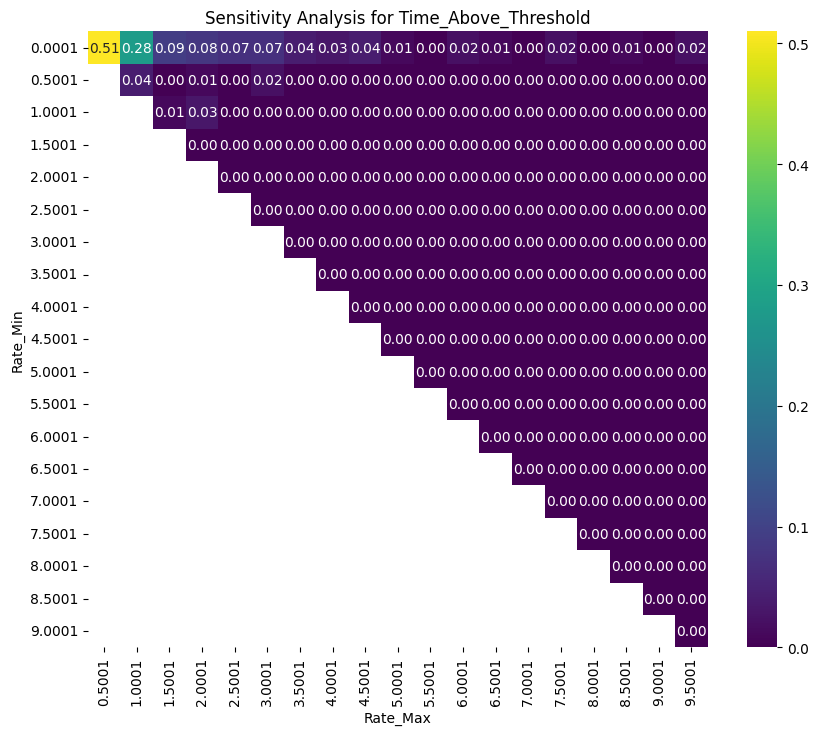

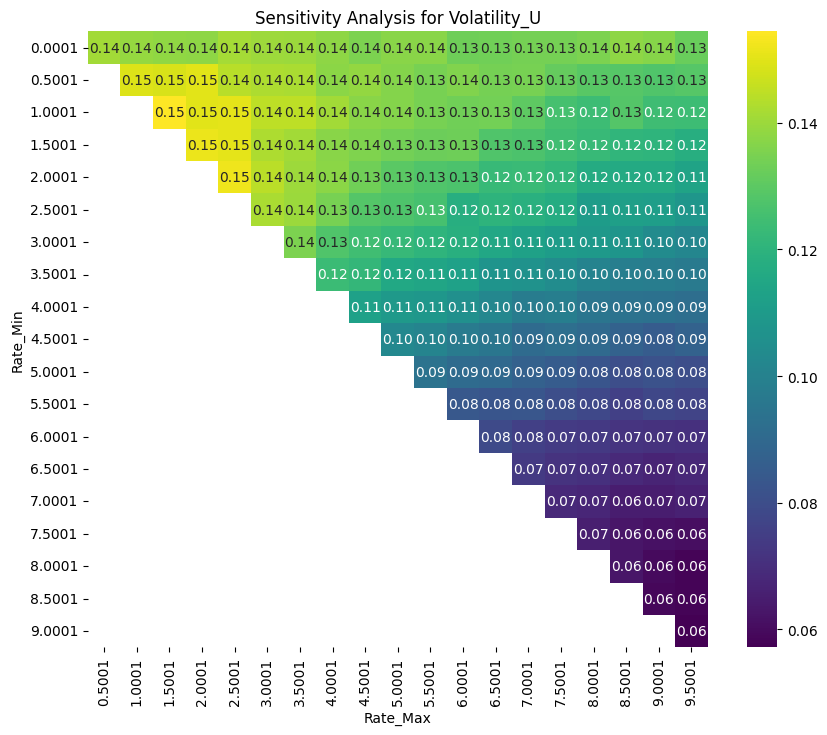

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a function to conduct sensitivity analysis
def sensitivity_analysis_rate_min_max(rate_min_range, rate_max_range, df, alpha, rho, b1, sigma, irm_class, num_steps, num_paths, target_u, threshold_u):
    """
    Conduct a sensitivity analysis for rate_min and rate_max parameters.

    Parameters:
    - rate_min_range: Tuple (min, max, step) for rate_min
    - rate_max_range: Tuple (min, max, step) for rate_max
    - df: DataFrame with calibrated parameters
    - alpha, rho, b1, sigma: W model parameters
    - irm_class: IRM class to evaluate
    - num_steps: Number of simulation steps
    - num_paths: Number of simulation paths
    - target_u: Target utilization ratio
    - threshold_u: Threshold utilization ratio

    Returns:
    - metrics_df: DataFrame with evaluation metrics for each combination of rate_min and rate_max
    """
    rate_min_values = np.arange(*rate_min_range)
    rate_max_values = np.arange(*rate_max_range)
    metrics_data = []

    for rate_min in rate_min_values:
        for rate_max in rate_max_values:
            if rate_min >= rate_max:
                continue

            irm = irm_class(rate_min=rate_min, rate_max=rate_max)
            sim_results = simulate_utilization_paths(
                alpha=alpha,
                rho=rho,
                b1=b1,
                sigma=sigma,
                W0=df['W'].iloc[-1],
                num_steps=num_steps,
                num_paths=num_paths,
                controller_type=irm
            )

            # Calculate metrics
            mse_total = 0.0
            time_above_threshold_total = 0.0
            vol_u_total = 0.0

            for path in sim_results:
                metrics = calculate_metrics(path, target_u, threshold_u)
                mse_total += metrics['MSE']
                time_above_threshold_total += metrics['Time_Above_Threshold']
                vol_u_total += metrics['Volatility_U']

            avg_metrics = {
                'Rate_Min': rate_min,
                'Rate_Max': rate_max,
                'MSE': mse_total / num_paths,
                'Time_Above_Threshold': time_above_threshold_total / num_paths,
                'Volatility_U': vol_u_total / num_paths,
            }
            metrics_data.append(avg_metrics)

    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df

# Define ranges for rate_min and rate_max
rate_min_range = (0.0001, 10, 0.5)  # 0.0001 to 10 with step size 0.5
rate_max_range = (0.0001, 10, 0.5)  # 0.0001 to 10 with step size 0.5

# Conduct sensitivity analysis
metrics_df = sensitivity_analysis_rate_min_max(
    rate_min_range=rate_min_range,
    rate_max_range=rate_max_range,
    df=df_last6,
    alpha=alpha,
    rho=rho,
    b1=b1,
    sigma=sigma,
    irm_class=SemiLogIRM,
    num_steps=365,
    num_paths=100,
    target_u=0.9,
    threshold_u=0.95
)

# Summary Statistics
print("\nOptimized IRM Metrics Summary:")
print(metrics_df.describe())

# Visualizations: Grid Chart for Metrics
metrics_to_plot = ['MSE', 'Time_Above_Threshold', 'Volatility_U']
for metric in metrics_to_plot:
    pivot_table = metrics_df.pivot(index='Rate_Min', columns='Rate_Max', values=metric)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f'Sensitivity Analysis for {metric}')
    plt.xlabel('Rate_Max')
    plt.ylabel('Rate_Min')
    plt.show()


### Step 8: Stablility of Optimal Parameter findings

##### GP

In [93]:
# stability_testing/general_stability_tests.py
from typing import Tuple, Type, List


def optimal_parameter_stability(
    df: pd.DataFrame,
    irm_class: Type,
    search_space: List,
    update_params_func: callable,
    re_runs: int = 100,
    n_calls: int = 30,
    random_state: int = 42,
    **opt_kwargs
) -> pd.DataFrame:
    """
    Assess parameter stability for any IRM.

    Parameters:
    - df: Original DataFrame used for calibration.
    - irm_class: IRM class to optimize.
    - search_space: List of skopt.Real defining the parameter search space.
    - update_params_func: Callable to update IRM parameters (specific to model).
    - irm_params: Dictionary of initial IRM parameters.
    - re_runs: Number of bootstrap samples.
    - n_calls: Number of optimization iterations per bootstrap.
    - random_state: Seed for reproducibility.
    - opt_kwargs: Additional keyword arguments for the optimization function.

    Returns:
    - bootstrap_df: DataFrame containing parameter estimates for each bootstrap.
    """
    np.random.seed(random_state)
    params_dict = {}

    for i in range(re_runs):

        # Optimize parameters on the bootstrap sample
        optimized_params = optimize_irm_parameters(
            df=df,
            irm_class=irm_class,
            search_space=search_space,
            update_params=update_params_func,
            target_u=opt_kwargs.get('target_u', 0.9),
            threshold_u=opt_kwargs.get('threshold_u', 0.95),
            num_steps=opt_kwargs.get('num_steps', 180),
            num_paths=opt_kwargs.get('num_paths', 30),
            weights=opt_kwargs.get('weights', {'MSE': 1.0, 'Time_Above_Threshold': 1.0, 'Volatility_U': 1.0}),
            n_calls=n_calls,
            model_input=parameters,
            random_state=random_state + i
        )

        # Convert list of parameters to a dictionary
        params_dict[i] = optimized_params.x

    df_r = pd.DataFrame(params_dict)
    df_r = df_r.T
    df_r.columns = ['rate_min', 'rate_max']
    return df_r

In [94]:
search_space

[Real(low=0.0001, high=10, prior='uniform', transform='normalize'),
 Real(low=0.0001, high=10, prior='uniform', transform='normalize')]

In [95]:
# Bootstrapping for SemiLogIRM
semilog_optimal_rerun_df = optimal_parameter_stability(
    df=df_last6,
    irm_class=SemiLogIRM,
    search_space=search_space,
    update_params_func=update_semilog,
    n_bootstraps=50,  # Adjust as needed
    n_calls=30,        # Adjust as needed
    random_state=42,
    model_input=parameters,
    target_u=0.9,
    threshold_u=0.95,
    num_steps=180,
    num_paths=100,
    weights={'MSE': 1.0, 'Time_Above_Threshold': 1.0, 'Volatility_U': 1.0}
)

# Display summary statistics
print("Bootstrapping Summary (SemiLogIRM):")
print(semilog_optimal_rerun_df.describe())


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0681
Function value obtained: 0.8135
Current minimum: 0.8135
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0506
Function value obtained: 0.8122
Current minimum: 0.8122
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0457
Function value obtained: 0.6472
Current minimum: 0.6472
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0486
Function value obtained: 0.6724
Current minimum: 0.6472
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0513
Function value obtained: 0.4434
Current minimum: 0.4434
Iteration No: 6 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.19790703893141165, 3.858039650904314]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.2771
Function value obtained: 0.2776
Current minimum: 0.2287
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.2364
Function value obtained: 0.8397
Current minimum: 0.2287
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3527
Function value obtained: 0.4458
Current minimum: 0.2287
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.8824865085787865, 1.7297727066770714]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4689
Function value obtained: 0.4324
Current minimum: 0.2287
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2784
Function value obtained: 0.2290
Current minimum: 0.2287
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3020
Function value obtained: 0.2475
Current minimum: 0.2287
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3015
Function value obtained: 0.7337
Current minimum: 0.2287
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3039
Function value obtained: 0.2362
Current minimum: 0.2287
Iteration No: 21 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.8487821558457895, 0.2553905212018386]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3633
Function value obtained: 0.8116
Current minimum: 0.2287
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.1637647394612323, 4.9905981865074125]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3477
Function value obtained: 0.5063
Current minimum: 0.2287
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.182618849702701, 2.4931018745027345]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3756
Function value obtained: 0.7057
Current minimum: 0.2287
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.521916387934452, 6.964364101659431]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3478
Function value obtained: 0.7367
Current minimum: 0.2287
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3616
Function value obtained: 0.2203
Current minimum: 0.2203
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.384469950199527, 8.469370826667397]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3846
Function value obtained: 0.6790
Current minimum: 0.2203
Optimized parameters: [0.0001, 9.40077075209337]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0568
Function value obtained: 0.6848
Current minimum: 0.6848
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0567
Function value obtained: 0.3911
Current minimum: 0.3911
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0575
Function value obtained: 0.8159
Current minimum: 0.3911
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0569
Function value obtained: 0.3359
Current minimum: 0.3359
Iteration No: 5 started. Evaluating 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.860971858793095, 3.6574768484131996]
  warnings.warn(
/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.0001083859172395, 3.4472916297872924]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.2960
Function value obtained: 0.6964
Current minimum: 0.2209
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.1483729862973355, 4.470101231406165]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.2746
Function value obtained: 0.4939
Current minimum: 0.2209
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.296552288520155, 9.552842883627271]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2958
Function value obtained: 0.8334
Current minimum: 0.2209
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.2260049076715815, 5.44641274895965]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.2781
Function value obtained: 0.5127
Current minimum: 0.2209
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.9432645765833989, 2.6737344415171918]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3034
Function value obtained: 0.3634
Current minimum: 0.2209
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.389145727172634, 1.9023621634846737]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3013
Function value obtained: 0.8241
Current minimum: 0.2209
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.939014700540247, 5.79676509729201]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3212
Function value obtained: 0.7559
Current minimum: 0.2209
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.822369784722978, 4.4210418257146085]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3044
Function value obtained: 0.8101
Current minimum: 0.2209
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.620697380314873, 3.649104213485313]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3073
Function value obtained: 0.7318
Current minimum: 0.2209
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.181102515475779, 6.139339110774805]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3308
Function value obtained: 0.5121
Current minimum: 0.2209
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.034824412104717, 3.2999451094074366]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3652
Function value obtained: 0.6302
Current minimum: 0.2209
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.2906030506797914, 5.094257865587823]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3291
Function value obtained: 0.5086
Current minimum: 0.2209
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0635
Function value obtained: 0.6300
Current minimum: 0.6300
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0586
Function value obtained: 0.7623
Current minimum: 0.6300
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0568
Function value obtained: 0.5427
Current minimum: 0.5427
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0588
Function value obtained: 0.7809
Current minimum: 0.5427
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.872983047717842, 8.087273431497051]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4439
Function value obtained: 0.3995
Current minimum: 0.2167
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3796
Function value obtained: 0.2187
Current minimum: 0.2167
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3926
Function value obtained: 0.2184
Current minimum: 0.2167
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4569
Function value obtained: 0.2176
Current minimum: 0.2167
Optimized parameters: [0.0001, 6.962535111564692]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0690
Function value obtained: 0.5887
Current minimum: 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.520990102071667, 2.900663579525915]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3480
Function value obtained: 0.7696
Current minimum: 0.2174
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.373060941163297, 7.343679549344738]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3614
Function value obtained: 0.8328
Current minimum: 0.2174
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.106816129954668, 7.410368772977727]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3287
Function value obtained: 0.7149
Current minimum: 0.2174
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.692078929076124, 7.559384908082876]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3415
Function value obtained: 0.7791
Current minimum: 0.2174
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.05516891349896, 5.618472360346258]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4381
Function value obtained: 0.8170
Current minimum: 0.2174
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4167
Function value obtained: 0.2161
Current minimum: 0.2161
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3831
Function value obtained: 0.2492
Current minimum: 0.2161
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.02009403808775515, 9.851388924188013]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4029
Function value obtained: 0.2635
Current minimum: 0.2161
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4258
Function value obtained: 0.2212
Current minimum: 0.2161
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4060
Function value obtained: 0.2194
Current minimum: 0.2161
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4173
Function value obtained: 0.2379
Current minimum: 0.2161
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4270
Function value obtained: 0.2215
Current minimum: 0.2161
Iteration No: 30 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.009558721350445, 0.3186224182992997]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2934
Function value obtained: 0.7427
Current minimum: 0.2187
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.293066746312645, 6.413429259778878]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3237
Function value obtained: 0.6088
Current minimum: 0.2187
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.887333679316677, 3.998774627250664]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3176
Function value obtained: 0.7459
Current minimum: 0.2187
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.681644552054809, 6.172241990696197]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3370
Function value obtained: 0.6888
Current minimum: 0.2187
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.988815896691818, 6.968577578701125]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3601
Function value obtained: 0.7571
Current minimum: 0.2187
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.1672952176819593, 2.7898788170145576]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3580
Function value obtained: 0.2711
Current minimum: 0.2187
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3518
Function value obtained: 0.2169
Current minimum: 0.2169
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3432
Function value obtained: 0.2252
Current minimum: 0.2169
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3478
Function value obtained: 0.2163
Current minimum: 0.2163
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3695
Function value obtained: 0.2316
Current minimum: 0.2163
Iteration No: 28 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.22478270054867, 2.697269307041047]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3275
Function value obtained: 0.7942
Current minimum: 0.2213
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.6146784666074693, 3.707308275312425]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3063
Function value obtained: 0.3323
Current minimum: 0.2213
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.329336366300398, 1.8054558573638169]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4558
Function value obtained: 0.4866
Current minimum: 0.2213
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.848800090256154, 4.557442090306953]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3589
Function value obtained: 0.6944
Current minimum: 0.2213
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.639936641047494, 2.2454791510628427]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3526
Function value obtained: 0.5108
Current minimum: 0.2213
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.6626800545107783, 1.2584630320872519]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3323
Function value obtained: 0.3952
Current minimum: 0.2213
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.37931617514608407, 7.956202130669972]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3493
Function value obtained: 0.3346
Current minimum: 0.2213
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.9283461045702461, 7.291260129948884]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3642
Function value obtained: 0.4107
Current minimum: 0.2213
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.9334355248213995, 5.684055903384722]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3404
Function value obtained: 0.5610
Current minimum: 0.2213
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.8574001496704415, 4.2424917289531985]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3116
Function value obtained: 0.7869
Current minimum: 0.2213
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.1338050056727695, 3.6035817564840995]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3135
Function value obtained: 0.7617
Current minimum: 0.2213
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3273
Function value obtained: 0.2721
Current minimum: 0.2213
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4638
Function value obtained: 0.2258
Current minimum: 0.2213
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.436740675551455, 7.553253685377102]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3718
Function value obtained: 0.5378
Current minimum: 0.2213
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4765
Function value obtained: 0.2411
Current minimum: 0.2213
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4095
Function value obtained: 0.2201
Current minimum: 0.2201
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3678
Function value obtained: 0.2388
Current minimum: 0.2201
Optimized parameters: [0.0012510729975066907, 4.391042959682111]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0570
Function value obtained: 0.6499
Cu

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.655193362756129, 9.16549875559833]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3885
Function value obtained: 0.7413
Current minimum: 0.2191
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3328
Function value obtained: 0.3563
Current minimum: 0.2191
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3532
Function value obtained: 0.2247
Current minimum: 0.2191
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3650
Function value obtained: 0.8431
Current minimum: 0.2191
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3832
Function value obtained: 0.5997
Current minimum: 0.2191
Iteration No: 24 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.3235562215117821, 2.0804513830710167]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4143
Function value obtained: 0.2902
Current minimum: 0.2170
Optimized parameters: [0.0001, 6.894702248074954]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0576
Function value obtained: 0.3474
Current minimum: 0.3474
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0556
Function value obtained: 0.7456
Current minimum: 0.3474
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0545
Function value obtained: 0.4633
Current minimum: 0.3474
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0554
Function value obtained: 0.8134
Current minimum: 0.3474
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.133652305743346, 9.512186025794067]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.2943
Function value obtained: 0.7635
Current minimum: 0.2183
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.098074529923838, 2.5235793846161543]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3010
Function value obtained: 0.7937
Current minimum: 0.2183
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.785742938378668, 0.8396561732118608]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3003
Function value obtained: 0.8291
Current minimum: 0.2183
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.0516149962861037, 1.4426477027130762]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3001
Function value obtained: 0.4453
Current minimum: 0.2183
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.0893108377377552, 8.173270881218679]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3411
Function value obtained: 0.4209
Current minimum: 0.2183
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.572962869775304, 1.8472473613591935]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3771
Function value obtained: 0.6629
Current minimum: 0.2183
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.5598802972839483, 3.081490402493911]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3619
Function value obtained: 0.4170
Current minimum: 0.2183
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.11612947994901, 8.402933202432534]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3518
Function value obtained: 0.8153
Current minimum: 0.2183
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0601
Function value obtained: 0.8200
Current minimum: 0.8200
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0579
Function value obtained: 0.6663
Current minimum: 0.6663
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0544
Function value obtained: 0.7686
Current minimum: 0.6663
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0642
Function value obtained: 0.8218
Current minimum: 0.6663
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.493369903429171, 1.1511629321918107]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3364
Function value obtained: 0.8242
Current minimum: 0.2163
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.828452195874607, 5.768109237192343]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3254
Function value obtained: 0.7843
Current minimum: 0.2163
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.826379602183412, 6.65445113585288]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3026
Function value obtained: 0.8392
Current minimum: 0.2163
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.251759968986559, 5.097154472284259]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.2971
Function value obtained: 0.5891
Current minimum: 0.2163
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.170807820377862, 3.716043974440052]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3176
Function value obtained: 0.5740
Current minimum: 0.2163
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.490487422627741, 5.087020022334598]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3072
Function value obtained: 0.8015
Current minimum: 0.2163
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.1345850626168628, 4.543102316329567]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3252
Function value obtained: 0.4010
Current minimum: 0.2163
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3540
Function value obtained: 0.2212
Current minimum: 0.2163
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.0432264890207552, 2.330432361471142]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3413
Function value obtained: 0.3645
Current minimum: 0.2163
Optimized parameters: [0.0001, 6.085936792396694]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0575
Function value obtained: 0.4009
Current minimum: 0.4009
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0587
Function value obtained: 0.8416
Current minimum: 0.4009
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0542
Function value obtained: 0.4587
Current minimum: 0.4009
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1347
Function value obtained: 0.6696
Current minimum: 0.4009
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.6421181613773523, 6.082464405274587]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.2587
Function value obtained: 0.4443
Current minimum: 0.2199
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3544
Function value obtained: 0.2555
Current minimum: 0.2199
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3379
Function value obtained: 0.4977
Current minimum: 0.2199
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3347
Function value obtained: 0.2391
Current minimum: 0.2199
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3416
Function value obtained: 0.2408
Current minimum: 0.2199
Iteration No: 19 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.757082568119631, 0.14032685594178967]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2715
Function value obtained: 0.7764
Current minimum: 0.2209
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.3436185080196665, 7.993580781653074]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2848
Function value obtained: 0.7690
Current minimum: 0.2209
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.1135548115343723, 8.243912418664658]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.2885
Function value obtained: 0.5164
Current minimum: 0.2209
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.6671729769191765, 8.424055409750613]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.2830
Function value obtained: 0.7386
Current minimum: 0.2209
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.945031134735476, 6.287367959404133]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2927
Function value obtained: 0.5781
Current minimum: 0.2209
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.57744582270604, 7.806827210111514]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.2987
Function value obtained: 0.6928
Current minimum: 0.2209
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.614858434238622, 7.821175163978892]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3058
Function value obtained: 0.8374
Current minimum: 0.2209
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.4173723575343113, 0.7234095945130318]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4701
Function value obtained: 0.5564
Current minimum: 0.2209
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.963974214087914, 7.647690022941857]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3462
Function value obtained: 0.7552
Current minimum: 0.2209
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.0575315367775526, 0.25037956393409144]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3282
Function value obtained: 0.3243
Current minimum: 0.2209
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.4032973969137025, 1.6148856668159879]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3722
Function value obtained: 0.2816
Current minimum: 0.2209
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3879
Function value obtained: 0.2380
Current minimum: 0.2209
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.811613753932549, 9.36137393428988]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4152
Function value obtained: 0.7880
Current minimum: 0.2209
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3810
Function value obtained: 0.3222
Current minimum: 0.2209
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0556
Function value obtained: 0.8279
Current minimum: 0.8279
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0548
Function value obtained: 0.7277
Current minimum: 0.7277
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0518
Function value obtained: 0.7234
Current minimum: 0.7234
Iteration No: 4 started. Evaluatin

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.47338118447623, 4.606875090545086]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2979
Function value obtained: 0.8353
Current minimum: 0.2162
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.9782369094992625, 0.21332982486576624]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.2856
Function value obtained: 0.8129
Current minimum: 0.2162
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.162014359252806, 1.371548201089657]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3159
Function value obtained: 0.4519
Current minimum: 0.2162
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.58581666654094, 6.613128145706122]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3022
Function value obtained: 0.5454
Current minimum: 0.2162
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.701926363882614, 9.601288436876386]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.2847
Function value obtained: 0.8075
Current minimum: 0.2162
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.68657505915408, 0.7829707116975884]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.2807
Function value obtained: 0.7730
Current minimum: 0.2162
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.5833326739275517, 2.9234176892126595]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2948
Function value obtained: 0.4254
Current minimum: 0.2162
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.6721339198598526, 9.445996814410764]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3183
Function value obtained: 0.4824
Current minimum: 0.2162
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.847406609501778, 6.196296206447266]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4644
Function value obtained: 0.6975
Current minimum: 0.2162
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.499335788265202, 9.684836891692962]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.2904
Function value obtained: 0.7387
Current minimum: 0.2162
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3140
Function value obtained: 0.2211
Current minimum: 0.2162
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3201
Function value obtained: 0.2467
Current minimum: 0.2162
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3443
Function value obtained: 0.8386
Current minimum: 0.2162
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3280
Function value obtained: 0.2456
Current minimum: 0.2162
Iteration No: 29 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.6034647057009526, 0.5469413270041522]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3648
Function value obtained: 0.5665
Current minimum: 0.2162
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.205815413595917, 3.9079307967797803]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3588
Function value obtained: 0.5845
Current minimum: 0.2162
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0588
Function value obtained: 0.7296
Current minimum: 0.7296
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0555
Function value obtained: 0.6813
Current minimum: 0.6813
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0594
Function value obtained: 0.8306
Current minimum: 0.6813
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0585
Function value obtained: 0.7225
Current minimum: 0.6813
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.1103478542385212, 0.841372481584946]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3012
Function value obtained: 0.4396
Current minimum: 0.2211
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.11204816127218925, 6.046710063198095]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3025
Function value obtained: 0.2811
Current minimum: 0.2211
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.565656449983481, 3.2131827667732495]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3227
Function value obtained: 0.7337
Current minimum: 0.2211
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.198174295882279, 4.962388304601202]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4655
Function value obtained: 0.7168
Current minimum: 0.2211
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.274680828505664, 9.767547265935457]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3035
Function value obtained: 0.6680
Current minimum: 0.2211
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3274
Function value obtained: 0.8437
Current minimum: 0.2211
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.245007246481849, 0.7316818738324317]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3318
Function value obtained: 0.7002
Current minimum: 0.2211
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.900178435808185, 1.58889070914284]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3131
Function value obtained: 0.8414
Current minimum: 0.2211
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3333
Function value obtained: 0.2622
Current minimum: 0.2211
Optimized parameters: [0.0001, 6.8979436205584825]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0622
Function value obtained: 0.6680
Current minimum: 0.6680
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0572
Function value obtained: 0.3849
Current minimum: 0.3849
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0555
Function value obtained: 0.8016
Current minimum: 0.3849
Iteration No: 4 star

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.561354335369458, 2.5197346979999606]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3295
Function value obtained: 0.7283
Current minimum: 0.2230
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.957855448789235, 1.3463504375387163]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3273
Function value obtained: 0.8304
Current minimum: 0.2230
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.41705281185898235, 2.485624251413019]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3225
Function value obtained: 0.2980
Current minimum: 0.2230
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.600186260677085, 2.1857982968551752]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3661
Function value obtained: 0.8033
Current minimum: 0.2230
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.6425599591780875, 1.4020818807380961]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.2825
Function value obtained: 0.7278
Current minimum: 0.2230
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.48964445666395084, 6.8777596806419705]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.2955
Function value obtained: 0.3441
Current minimum: 0.2230
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.9225436879573765, 5.544225377648897]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3137
Function value obtained: 0.7025
Current minimum: 0.2230
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.492765901246947, 5.941382101933622]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4321
Function value obtained: 0.4432
Current minimum: 0.2230
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.0149806824141907, 1.3139865882878357]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.2949
Function value obtained: 0.3381
Current minimum: 0.2230
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.017985060958609, 2.345413743068793]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3216
Function value obtained: 0.4562
Current minimum: 0.2230
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.215555140604316, 0.23099604174863653]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3160
Function value obtained: 0.8358
Current minimum: 0.2230
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.2448797958787794, 4.388348504312518]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3226
Function value obtained: 0.5791
Current minimum: 0.2230
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0571
Function value obtained: 0.8263
Current minimum: 0.8263
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0559
Function value obtained: 0.6271
Current minimum: 0.6271
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0538
Function value obtained: 0.7415
Current minimum: 0.6271
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0553
Function value obtained: 0.4315
Current minimum: 0.4315
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.7245442874385466, 2.2139917092858648]
  warnings.warn(
/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.938703409596709, 2.7488200289605]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3645
Function value obtained: 0.8413
Current minimum: 0.2226
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.9435604481513997, 9.506310595851456]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3038
Function value obtained: 0.6584
Current minimum: 0.2226
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.316330241949595, 8.771054224560144]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3407
Function value obtained: 0.6766
Current minimum: 0.2226
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3592
Function value obtained: 0.2678
Current minimum: 0.2226
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.314706016316327, 7.4605167544217945]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3072
Function value obtained: 0.7687
Current minimum: 0.2226
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.525734800786765, 4.981965146698377]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4119
Function value obtained: 0.7738
Current minimum: 0.2226
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3500
Function value obtained: 0.2776
Current minimum: 0.2226
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3266
Function value obtained: 0.2392
Current minimum: 0.2226
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3461
Function value obtained: 0.2330
Current minimum: 0.2226
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3384
Function value obtained: 0.2304
Current minimum: 0.2226
Iteration No: 26 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.5110028392391599, 4.951786127872588]
  warnings.warn(
/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.4075284516726874, 7.31940691312611]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.2651
Function value obtained: 0.5348
Current minimum: 0.2135
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.444072745183132, 9.690446026688383]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2821
Function value obtained: 0.5484
Current minimum: 0.2135
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.249406572496785, 9.195544301759007]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2713
Function value obtained: 0.5246
Current minimum: 0.2135
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.886280808173668, 1.5112625609072057]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.2708
Function value obtained: 0.8406
Current minimum: 0.2135
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.276395586947142, 1.3904314625703451]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.2889
Function value obtained: 0.8216
Current minimum: 0.2135
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.188108699290108, 8.8408497727998]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2795
Function value obtained: 0.7923
Current minimum: 0.2135
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.027426213820472, 4.508278423488876]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3404
Function value obtained: 0.4832
Current minimum: 0.2135
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.289629469377219, 9.047516413299654]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.2811
Function value obtained: 0.7959
Current minimum: 0.2135
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.98096945813628, 6.711614723259989]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.2960
Function value obtained: 0.8141
Current minimum: 0.2135
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.225768638343918, 2.715027426393052]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3569
Function value obtained: 0.4800
Current minimum: 0.2135
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.38520877657705, 6.402982146968989]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3585
Function value obtained: 0.6031
Current minimum: 0.2135
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.5721302665082297, 4.786754454955476]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3054
Function value obtained: 0.6113
Current minimum: 0.2135
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.035434194874999, 6.564235926424352]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5076
Function value obtained: 0.7582
Current minimum: 0.2135
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.567112752001179, 3.770997778700088]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3035
Function value obtained: 0.4320
Current minimum: 0.2135
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.236102860248932, 9.297000357477318]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3254
Function value obtained: 0.8189
Current minimum: 0.2135
Optimized parameters: [0.00011364893098894672, 8.129436422181817]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0593
Function value obtained: 0.6536
Current minimum: 0.6536
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0565
Function value obtained: 0.4776
Current minimum: 0.4776
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0533
Function value obtained: 0.4040
Current minimum: 0.4040
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0530
Function value obtained: 0.7780
Current minimum: 0.4040
Iteration No: 5 sta

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.271271378607967, 0.3210247093409369]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3311
Function value obtained: 0.8210
Current minimum: 0.2180
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.3118615081361913, 5.677074434691113]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.2915
Function value obtained: 0.5140
Current minimum: 0.2180
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.22920218963551, 3.982367369046091]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3078
Function value obtained: 0.8335
Current minimum: 0.2180
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.581487352847912, 4.101248036614899]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3056
Function value obtained: 0.8261
Current minimum: 0.2180
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.568005017545851, 3.6689097040973944]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3323
Function value obtained: 0.6779
Current minimum: 0.2180
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.280124005498922, 2.073354593369144]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3258
Function value obtained: 0.4752
Current minimum: 0.2180
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.79914273138214, 4.477300015335683]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4662
Function value obtained: 0.4686
Current minimum: 0.2180
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.928152993645844, 3.1673740847524523]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3677
Function value obtained: 0.7841
Current minimum: 0.2180
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.829127872060619, 6.718300273721182]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4454
Function value obtained: 0.7448
Current minimum: 0.2180
Optimized parameters: [0.0001, 6.308382711889839]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0603
Function value obtained: 0.8422
Current minimum: 0.8422
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0581
Function value obtained: 0.3642
Current minimum: 0.3642
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0554
Function value obtained: 0.2992
Current minimum: 0.2992
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0554
Function value obtained: 0.8346
Current minimum: 0.2992
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8132890494954955, 5.715177652187833]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.2743
Function value obtained: 0.3809
Current minimum: 0.2201
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.2143041700054664, 0.10956277580927222]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3021
Function value obtained: 0.5304
Current minimum: 0.2201
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3250
Function value obtained: 0.6173
Current minimum: 0.2201
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2882
Function value obtained: 0.2227
Current minimum: 0.2201
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3102
Function value obtained: 0.2348
Current minimum: 0.2201
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3152
Function value obtained: 0.2261
Current minimum: 0.2201
Iteration No: 20 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.48247912579699054, 7.238059506113562]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3015
Function value obtained: 0.3539
Current minimum: 0.2201
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2593
Function value obtained: 0.2570
Current minimum: 0.2201
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.8082161015810705, 7.19734216798252]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.2904
Function value obtained: 0.7466
Current minimum: 0.2201
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.06393703812936, 6.30383725985059]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3744
Function value obtained: 0.7928
Current minimum: 0.2201
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.5987244465661323, 2.15263186538144]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3058
Function value obtained: 0.5883
Current minimum: 0.2201
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.5302127205640135, 5.598520663389353]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3057
Function value obtained: 0.7309
Current minimum: 0.2201
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.66918383232189, 5.3543030861607335]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.2996
Function value obtained: 0.7811
Current minimum: 0.2201
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8144229190833432, 1.000378942018107]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3298
Function value obtained: 0.3211
Current minimum: 0.2201
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.6168738556586915, 4.385903180499879]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3060
Function value obtained: 0.7772
Current minimum: 0.2201
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.127179254436172, 7.905589685085762]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3093
Function value obtained: 0.5908
Current minimum: 0.2201
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.403137435092729, 1.4064527979190322]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4620
Function value obtained: 0.8227
Current minimum: 0.2201
Optimized parameters: [0.0001, 9.42461625918993]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0550
Function value obtained: 0.5757
Current minimum: 0.5757
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0531
Function value obtained: 0.4576
Current minimum: 0.4576
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0514
Function value obtained: 0.5279
Current minimum: 0.4576
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0532
Function value obtained: 0.8262
Current minimum: 0.4576
Iteration No: 5 started. Evaluating 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.655666715071403, 5.844657943771297]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2712
Function value obtained: 0.8380
Current minimum: 0.2266
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.1409092459619945, 2.544143794971155]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.2977
Function value obtained: 0.7925
Current minimum: 0.2266
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.104194065406518, 9.183856556775439]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2656
Function value obtained: 0.6674
Current minimum: 0.2266
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2619
Function value obtained: 0.2700
Current minimum: 0.2266
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.2817
Function value obtained: 0.2709
Current minimum: 0.2266
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.2971
Function value obtained: 0.2698
Current minimum: 0.2266
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2567
Function value obtained: 0.2691
Current minimum: 0.2266
Iteration No: 22 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.1505590049951, 5.1237431117502545]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3395
Function value obtained: 0.8185
Current minimum: 0.2182
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.369118881972499, 6.580073475693447]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3350
Function value obtained: 0.8189
Current minimum: 0.2182
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.241164149881718, 6.327966443561495]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3198
Function value obtained: 0.7237
Current minimum: 0.2182
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.778023221812328, 4.413854149454824]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3609
Function value obtained: 0.8380
Current minimum: 0.2182
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.424818676624729, 8.405809909961059]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4364
Function value obtained: 0.8042
Current minimum: 0.2182
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.079523494660336, 8.770159246790431]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3712
Function value obtained: 0.8303
Current minimum: 0.2182
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.922959226036527, 3.72758341769311]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3647
Function value obtained: 0.8409
Current minimum: 0.2182
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.6974960422883703, 8.993290656799402]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3676
Function value obtained: 0.6365
Current minimum: 0.2182
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.6115946641733527, 4.006982096523831]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3879
Function value obtained: 0.3310
Current minimum: 0.2182
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.85619051949899, 0.2713998064500614]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3873
Function value obtained: 0.7817
Current minimum: 0.2182
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.680515100659412, 4.535830745568813]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3935
Function value obtained: 0.7792
Current minimum: 0.2182
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4576
Function value obtained: 0.2161
Current minimum: 0.2161
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4337
Function value obtained: 0.2165
Current minimum: 0.2161
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5760
Function value obtained: 0.2289
Current minimum: 0.2161
Optimized parameters: [0.0001, 2.6019043058684646]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0538
Function value obtained: 0.6949
Current minimum:

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.374602366195726, 0.8167148763212121]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3506
Function value obtained: 0.7094
Current minimum: 0.2144
Optimized parameters: [0.0001, 8.218691774519543]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0586
Function value obtained: 0.2944
Current minimum: 0.2944
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0537
Function value obtained: 0.3403
Current minimum: 0.2944
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0542
Function value obtained: 0.6155
Current minimum: 0.2944
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0518
Function value obtained: 0.8037
Current minimum: 0.2944
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.726883879225548, 5.225568664622974]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3795
Function value obtained: 0.7397
Current minimum: 0.2191
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4573
Function value obtained: 0.2263
Current minimum: 0.2191
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.532180787435862, 8.24310390024703]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3771
Function value obtained: 0.6900
Current minimum: 0.2191
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.409895601986445, 9.218694578748067]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3915
Function value obtained: 0.8341
Current minimum: 0.2191
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.844763107236592, 5.499591450729094]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3679
Function value obtained: 0.8276
Current minimum: 0.2191
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.316264607859583, 8.7645598635112]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3848
Function value obtained: 0.8210
Current minimum: 0.2191
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.3066765375193408, 5.414749411149153]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4623
Function value obtained: 0.4179
Current minimum: 0.2191
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3900
Function value obtained: 0.2148
Current minimum: 0.2148
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5021
Function value obtained: 0.2180
Current minimum: 0.2148
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4634
Function value obtained: 0.2232
Current minimum: 0.2148
Optimized parameters: [0.0001, 5.320935811779359]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0552
Function value obtained: 0.8286
Current minimum: 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.65062260742932, 7.006419309572517]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.2641
Function value obtained: 0.6886
Current minimum: 0.2183
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2875
Function value obtained: 0.2551
Current minimum: 0.2183
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2995
Function value obtained: 0.2344
Current minimum: 0.2183
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3263
Function value obtained: 0.2332
Current minimum: 0.2183
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3150
Function value obtained: 0.2423
Current minimum: 0.2183
Iteration No: 21 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.825081669771127, 1.584073606719974]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.2821
Function value obtained: 0.8278
Current minimum: 0.2187
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3738
Function value obtained: 0.4716
Current minimum: 0.2187
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2807
Function value obtained: 0.3715
Current minimum: 0.2187
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3784
Function value obtained: 0.2268
Current minimum: 0.2187
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2854
Function value obtained: 0.3184
Current minimum: 0.2187
Iteration No: 18 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.343188374356067, 1.1525025623422656]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2992
Function value obtained: 0.7135
Current minimum: 0.2187
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.145540440617611, 9.22546588003223]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3134
Function value obtained: 0.7176
Current minimum: 0.2187
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.185096772046015, 8.303448300357305]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3109
Function value obtained: 0.5231
Current minimum: 0.2187
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.715315959227018, 9.54393968083056]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2924
Function value obtained: 0.8388
Current minimum: 0.2187
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3034
Function value obtained: 0.2519
Current minimum: 0.2187
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3169
Function value obtained: 0.2333
Current minimum: 0.2187
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.204482412946855, 2.8897864263525763]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3117
Function value obtained: 0.7578
Current minimum: 0.2187
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.611246355378626, 6.657869220961124]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3250
Function value obtained: 0.8068
Current minimum: 0.2187
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.475439932332225, 2.164401114350988]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3237
Function value obtained: 0.8032
Current minimum: 0.2187
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3484
Function value obtained: 0.2635
Current minimum: 0.2187
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3297
Function value obtained: 0.2522
Current minimum: 0.2187
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3072
Function value obtained: 0.2188
Current minimum: 0.2187
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3159
Function value obtained: 0.2127
Current minimum: 0.2127
Optimized parameters: [0.0001

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.496991063376801, 0.07506802993259509]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.2754
Function value obtained: 0.6430
Current minimum: 0.2170
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.124840755761574, 6.360238158234157]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2818
Function value obtained: 0.5092
Current minimum: 0.2170
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.330023349840933, 6.600910786248773]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2888
Function value obtained: 0.6040
Current minimum: 0.2170
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.90984498375877, 6.078803461059896]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3029
Function value obtained: 0.8400
Current minimum: 0.2170
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.091408110086802, 0.6597591760831699]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3195
Function value obtained: 0.7899
Current minimum: 0.2170
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3031
Function value obtained: 0.2439
Current minimum: 0.2170
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.1971734182601175, 5.90231101301482]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3123
Function value obtained: 0.5177
Current minimum: 0.2170
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.549150709084673, 2.6271695261367585]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.2939
Function value obtained: 0.8376
Current minimum: 0.2170
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.9597319263902293, 1.360369886179599]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.2997
Function value obtained: 0.4389
Current minimum: 0.2170
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3183
Function value obtained: 0.2370
Current minimum: 0.2170
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3187
Function value obtained: 0.2294
Current minimum: 0.2170
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3163
Function value obtained: 0.2343
Current minimum: 0.2170
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3183
Function value obtained: 0.2315
Current minimum: 0.2170
Iteration No: 29 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.420187911166105, 2.0270705513813505]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3376
Function value obtained: 0.6606
Current minimum: 0.2145
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.422346467005724, 7.265462642499908]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3399
Function value obtained: 0.8018
Current minimum: 0.2145
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.675654493810664, 7.61708445810313]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3121
Function value obtained: 0.7446
Current minimum: 0.2145
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.359112008684661, 9.355513226630032]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3369
Function value obtained: 0.7351
Current minimum: 0.2145
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.178692161260609, 5.7075802877987485]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3423
Function value obtained: 0.7935
Current minimum: 0.2145
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.040995506169734, 2.5289677063391434]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3521
Function value obtained: 0.7532
Current minimum: 0.2145
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.5129198837527045, 3.2981175621407846]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3397
Function value obtained: 0.5099
Current minimum: 0.2145
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.7171079569933991, 7.8091924656027]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3574
Function value obtained: 0.4817
Current minimum: 0.2145
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8398506605336242, 3.910193052845002]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3470
Function value obtained: 0.3555
Current minimum: 0.2145
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.682419110146365, 6.217193612735958]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3609
Function value obtained: 0.6882
Current minimum: 0.2145
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3781
Function value obtained: 0.2398
Current minimum: 0.2145
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3667
Function value obtained: 0.2614
Current minimum: 0.2145
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.1042446318747983, 6.955058994323453]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3788
Function value obtained: 0.5139
Current minimum: 0.2145
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.664031554127246, 3.994655311037124]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3784
Function value obtained: 0.7770
Current minimum: 0.2145
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.195228097455965, 5.513732178253844]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3798
Function value obtained: 0.5833
Current minimum: 0.2145
Optimized parameters: [0.0001, 7.067338908012711]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1240
Function value obtained: 0.7348
Current minimum: 0.7348
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1182
Function value obtained: 0.5723
Current minimum: 0.5723
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0771
Function value obtained: 0.7984
Current minimum: 0.5723
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0644
Function value obtained: 0.4296
Current minimum: 0.4296
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.474401748570441, 2.291587348712118]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3336
Function value obtained: 0.8022
Current minimum: 0.2181
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.5909230867805686, 8.472693119083013]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3194
Function value obtained: 0.6292
Current minimum: 0.2181
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3250
Function value obtained: 0.3909
Current minimum: 0.2181
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.652986950393974, 8.536981876224058]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3722
Function value obtained: 0.8352
Current minimum: 0.2181
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.146993532599231, 6.833010881261433]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3392
Function value obtained: 0.5918
Current minimum: 0.2181
Optimized parameters: [0.0001, 9.019618317645378]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0632
Function value obtained: 0.8314
Current minimum: 0.8314
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0593
Function value obtained: 0.3482
Current minimum: 0.3482
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0556
Function value obtained: 0.7686
Current minimum: 0.3482
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0578
Function value obtained: 0.6344
Current minimum: 0.3482
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.6528737798326946, 2.1253078852514498]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3211
Function value obtained: 0.3310
Current minimum: 0.2188
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4134
Function value obtained: 0.2249
Current minimum: 0.2188
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.1453759491851305, 7.174785412278191]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.2773
Function value obtained: 0.4175
Current minimum: 0.2188
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.73191818053267, 3.2915715141652995]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3239
Function value obtained: 0.8395
Current minimum: 0.2188
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.794582913727844, 1.4883451635404057]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2919
Function value obtained: 0.8121
Current minimum: 0.2188
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.9056240940822864, 7.834199089996139]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3821
Function value obtained: 0.4857
Current minimum: 0.2188
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.8534907661036217, 6.334670054613878]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4310
Function value obtained: 0.4878
Current minimum: 0.2188
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.066787233192002, 7.926578198904366]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3487
Function value obtained: 0.7592
Current minimum: 0.2188
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.671636800997563, 0.21537827269070203]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3798
Function value obtained: 0.6583
Current minimum: 0.2188
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.46741778593916, 0.43486603716915356]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3776
Function value obtained: 0.6486
Current minimum: 0.2188
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.4091092144862354, 9.864313427459834]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4629
Function value obtained: 0.4650
Current minimum: 0.2188
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4133
Function value obtained: 0.2256
Current minimum: 0.2188
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3557
Function value obtained: 0.2242
Current minimum: 0.2188
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3944
Function value obtained: 0.2330
Current minimum: 0.2188
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.8362109045739645, 0.2125077576686437]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3868
Function value obtained: 0.8092
Current minimum: 0.2188
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.6248849163544006, 5.123869122873642]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3643
Function value obtained: 0.6164
Current minimum: 0.2188
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.350212607722831, 9.510742710937766]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3721
Function value obtained: 0.7982
Current minimum: 0.2188
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1275
Function value obtained: 0.8382
Current minimum: 0.8382
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0620
Function value obtained: 0.4217
Current minimum: 0.4217
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0640
Function value obtained: 0.8099
Current minimum: 0.4217
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0705
Function value obtained: 0.8027
Current minimum: 0.4217
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.215965296030319, 7.789829672338743]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2693
Function value obtained: 0.8319
Current minimum: 0.2232
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.833585231353187, 0.9086944495995447]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3177
Function value obtained: 0.8299
Current minimum: 0.2232
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.588611359069284, 3.5318267902079943]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3157
Function value obtained: 0.6767
Current minimum: 0.2232
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.154335808871184, 5.611961518675372]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3290
Function value obtained: 0.7180
Current minimum: 0.2232
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.068768146124984, 7.0594794633305185]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3605
Function value obtained: 0.7592
Current minimum: 0.2232
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.968383087368709, 7.271608326727555]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4075
Function value obtained: 0.8142
Current minimum: 0.2232
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.560604217748828, 1.0386038783113147]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3593
Function value obtained: 0.7694
Current minimum: 0.2232
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.695603511081659, 2.7554397797363785]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3653
Function value obtained: 0.8389
Current minimum: 0.2232
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.355014467855515, 7.0297465307543225]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4716
Function value obtained: 0.7335
Current minimum: 0.2232
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4381
Function value obtained: 0.2280
Current minimum: 0.2232
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3328
Function value obtained: 0.2805
Current minimum: 0.2232
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.906288299777369, 8.896585714621889]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3710
Function value obtained: 0.7889
Current minimum: 0.2232
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.958910251461202, 3.9073653291421264]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3701
Function value obtained: 0.8395
Current minimum: 0.2232
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.655734199553699, 9.305593996830218]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3662
Function value obtained: 0.5626
Current minimum: 0.2232
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.509525491529486, 1.1914622946668558]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3574
Function value obtained: 0.8381
Current minimum: 0.2232
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.4941457314599547, 9.781757866959303]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5089
Function value obtained: 0.4673
Current minimum: 0.2232
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0581
Function value obtained: 0.8341
Current minimum: 0.8341
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0526
Function value obtained: 0.7461
Current minimum: 0.7461
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0531
Function value obtained: 0.7704
Current minimum: 0.7461
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0539
Function value obtained: 0.3548
Current minimum: 0.3548
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.644697103441781, 3.384554010947784]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3007
Function value obtained: 0.7364
Current minimum: 0.2188
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.2911134379381406, 0.9815429196024908]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3175
Function value obtained: 0.5489
Current minimum: 0.2188
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.880112431963812, 7.0165158715044145]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3138
Function value obtained: 0.7507
Current minimum: 0.2188
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.495334856371048, 3.8569097254533955]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4070
Function value obtained: 0.8362
Current minimum: 0.2188
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.269548375116934, 1.2312885261413262]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3258
Function value obtained: 0.7015
Current minimum: 0.2188
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.722592677896964, 5.8295802694212675]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3667
Function value obtained: 0.7432
Current minimum: 0.2188
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.03674872184950022, 3.854002087948524]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4480
Function value obtained: 0.2471
Current minimum: 0.2188
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.3064553816120859, 8.640954748457526]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4301
Function value obtained: 0.4468
Current minimum: 0.2188
Optimized parameters: [0.0001, 5.769050996559222]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0622
Function value obtained: 0.7599
Current minimum: 0.7599
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0579
Function value obtained: 0.7766
Current minimum: 0.7599
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0579
Function value obtained: 0.4633
Current minimum: 0.4633
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0554
Function value obtained: 0.8205
Current minimum: 0.4633
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.161506371682323, 0.24242529674231938]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.6059
Function value obtained: 0.8357
Current minimum: 0.2173
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.9040326247516175, 6.25710437734526]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3551
Function value obtained: 0.7065
Current minimum: 0.2173
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.456612473674372, 1.586429096262154]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3389
Function value obtained: 0.8374
Current minimum: 0.2173
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.20439526198606, 5.598345707291717]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3091
Function value obtained: 0.5931
Current minimum: 0.2173
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.1042406186152744, 5.920721820213862]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3869
Function value obtained: 0.5838
Current minimum: 0.2173
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.704094573454706, 3.254328281444794]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4147
Function value obtained: 0.6802
Current minimum: 0.2173
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.396787947754483, 4.18954037104795]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3638
Function value obtained: 0.6647
Current minimum: 0.2173
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.678927025298132, 3.689259504443829]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4133
Function value obtained: 0.8084
Current minimum: 0.2173
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.4327253679125027, 5.733272679431222]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3982
Function value obtained: 0.4433
Current minimum: 0.2173
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.543966374543189, 7.033942093015186]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4130
Function value obtained: 0.8058
Current minimum: 0.2173
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.508989584373367, 7.143525101197404]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3572
Function value obtained: 0.6768
Current minimum: 0.2173
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.0577874765227335, 5.587236528277484]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3461
Function value obtained: 0.7100
Current minimum: 0.2173
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.898899701867104, 7.9682022225467986]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3570
Function value obtained: 0.7863
Current minimum: 0.2173
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.9316980126789085, 8.080491470423329]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5920
Function value obtained: 0.5023
Current minimum: 0.2173
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4528
Function value obtained: 0.2491
Current minimum: 0.2173
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4275
Function value obtained: 0.2327
Current minimum: 0.2173
Optimized parameters: [0.0001, 7.979485344209144]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0587
Function value obtained: 0.6378
Current minimum: 0.6378
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0545
Function value obtained: 0.5662
Current minimum: 0.5662
Iterati

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.550563248900147, 1.5780336779871809]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3048
Function value obtained: 0.8240
Current minimum: 0.2139
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.861559236406445, 0.6434761039122207]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3493
Function value obtained: 0.5909
Current minimum: 0.2139
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3683
Function value obtained: 0.2306
Current minimum: 0.2139
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3438
Function value obtained: 0.2215
Current minimum: 0.2139
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3420
Function value obtained: 0.2214
Current minimum: 0.2139
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3255
Function value obtained: 0.2238
Current minimum: 0.2139
Iteration No: 26 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.087438473925807, 3.342120480836848]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3101
Function value obtained: 0.6428
Current minimum: 0.2172
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.485272177005252, 7.7209068350591865]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3614
Function value obtained: 0.5409
Current minimum: 0.2172
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3449
Function value obtained: 0.2183
Current minimum: 0.2172
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.726622521051622, 5.04699109867871]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3497
Function value obtained: 0.7401
Current minimum: 0.2172
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3697
Function value obtained: 0.2277
Current minimum: 0.2172
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.057420504013693, 1.9977862074625548]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3659
Function value obtained: 0.8133
Current minimum: 0.2172
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.314471222141269, 2.17493645960188]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3569
Function value obtained: 0.6488
Current minimum: 0.2172
Optimized parameters: [0.000739048588048611, 3.9194922536780723]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0597
Function value obtained: 0.5301
Current minimum: 0.5301
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0546
Function value obtained: 0.4480
Current minimum: 0.4480
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0533
Function value obtained: 0.6122
Current minimum: 0.4480
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0567
Function value obtained: 0.6086
Current minimum: 0.4480
Iteration No: 5 star

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.016421869935848, 2.9865650499506105]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2706
Function value obtained: 0.6379
Current minimum: 0.2231
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.429073516845906, 9.236116016461315]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.2799
Function value obtained: 0.7389
Current minimum: 0.2231
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.6489262884242155, 1.3546195887100756]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4060
Function value obtained: 0.7743
Current minimum: 0.2231
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.266603392346784, 8.971079219481517]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3752
Function value obtained: 0.7284
Current minimum: 0.2231
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.197040404704298, 8.121459051776196]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3728
Function value obtained: 0.7251
Current minimum: 0.2231
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4811
Function value obtained: 0.2207
Current minimum: 0.2207
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4755
Function value obtained: 0.2258
Current minimum: 0.2207
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.600602668336415, 3.0234603753096714]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3352
Function value obtained: 0.8075
Current minimum: 0.2207
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.6856532151423792, 4.794880668949302]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3370
Function value obtained: 0.3561
Current minimum: 0.2207
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.5212285573840463, 7.842714689973493]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3249
Function value obtained: 0.5474
Current minimum: 0.2207
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.2994113429472827, 6.0200658433723655]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4137
Function value obtained: 0.5149
Current minimum: 0.2207
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.477672034938943, 3.579962443262699]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3577
Function value obtained: 0.5131
Current minimum: 0.2207
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.949031940784358, 6.176530008297295]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3434
Function value obtained: 0.7520
Current minimum: 0.2207
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.9748763921861514, 6.0478175780791625]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3557
Function value obtained: 0.4899
Current minimum: 0.2207
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.878512394315565, 3.9157110531027137]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3657
Function value obtained: 0.8112
Current minimum: 0.2207
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.749309439532063, 0.2994851445104812]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3993
Function value obtained: 0.8396
Current minimum: 0.2207
Optimized parameters: [0.0001, 9.228509965314421]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0583
Function value obtained: 0.7335
Current minimum: 0.7335
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0541
Function value obtained: 0.8411
Current minimum: 0.7335
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0512
Function value obtained: 0.7187
Current minimum: 0.7187
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0547
Function value obtained: 0.7371
Current minimum: 0.7187
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.806252071160543, 2.069040634915745]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3356
Function value obtained: 0.8405
Current minimum: 0.2257
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.2601937778032415, 5.401765582504982]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3564
Function value obtained: 0.7604
Current minimum: 0.2257
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3234
Function value obtained: 0.2866
Current minimum: 0.2257
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.387411306791844, 7.691667971064364]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5609
Function value obtained: 0.7308
Current minimum: 0.2257
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.52581010053651, 7.686153909527958]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3988
Function value obtained: 0.8234
Current minimum: 0.2257
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.09403240919618368, 0.654451387646411]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3984
Function value obtained: 0.3563
Current minimum: 0.2257
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.266496693544131, 3.7310787378603405]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3162
Function value obtained: 0.7955
Current minimum: 0.2257
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3107
Function value obtained: 0.2640
Current minimum: 0.2257
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3142
Function value obtained: 0.2541
Current minimum: 0.2257
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3088
Function value obtained: 0.2219
Current minimum: 0.2219
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3003
Function value obtained: 0.2484
Current minimum: 0.2219
Optimized parameters: [0.0001

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.41347047323224, 1.2415820146739636]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3771
Function value obtained: 0.8000
Current minimum: 0.2192
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8515439688647749, 9.445158578595496]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3205
Function value obtained: 0.4019
Current minimum: 0.2192
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.105633867587635, 0.07302507663203946]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3343
Function value obtained: 0.8171
Current minimum: 0.2192
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.950724117752884, 3.8601093059643783]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4325
Function value obtained: 0.8136
Current minimum: 0.2192
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.1377829233575905, 1.5549321071628526]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3064
Function value obtained: 0.4489
Current minimum: 0.2192
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.048205508598167, 8.0200457769929]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3196
Function value obtained: 0.7603
Current minimum: 0.2192
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.232345050413034, 5.619171938048229]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3139
Function value obtained: 0.7171
Current minimum: 0.2192
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.256756677151357, 8.02747707618883]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3141
Function value obtained: 0.8197
Current minimum: 0.2192
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.997755279605828, 7.807331076149149]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3933
Function value obtained: 0.7082
Current minimum: 0.2192
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3522
Function value obtained: 0.2390
Current minimum: 0.2192
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3212
Function value obtained: 0.2448
Current minimum: 0.2192
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3726
Function value obtained: 0.2180
Current minimum: 0.2180
Optimized parameters: [0.0001, 7.6167145439316695]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0597
Function value obtained: 0.5533
Current minimum:

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.4878255689511288, 1.4771116864500218]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3247
Function value obtained: 0.3873
Current minimum: 0.2254
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.409660109599366, 5.731715406175573]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3250
Function value obtained: 0.6043
Current minimum: 0.2254
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.116152735107033, 6.947831690739484]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3375
Function value obtained: 0.8312
Current minimum: 0.2254
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.29840045888755184, 3.3144614949689606]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3734
Function value obtained: 0.2882
Current minimum: 0.2254
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.8768720112987998, 8.30911342566651]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3916
Function value obtained: 0.5790
Current minimum: 0.2254
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.410206607571703, 0.22603789963908805]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4183
Function value obtained: 0.5509
Current minimum: 0.2254
Optimized parameters: [0.00014599231496861505, 8.761509258005475]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0569
Function value obtained: 0.4336
Current minimum: 0.4336
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0535
Function value obtained: 0.6606
Current minimum: 0.4336
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0545
Function value obtained: 0.8435
Current minimum: 0.4336
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0532
Function value obtained: 0.7488
Current minimum: 0.4336
Iteration No: 5 sta

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.696316226722114, 8.620661999588044]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3497
Function value obtained: 0.7483
Current minimum: 0.2172
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8493772133325669, 1.7345132578395523]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4096
Function value obtained: 0.3305
Current minimum: 0.2172
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4367
Function value obtained: 0.2475
Current minimum: 0.2172
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4169
Function value obtained: 0.2195
Current minimum: 0.2172
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3986
Function value obtained: 0.2285
Current minimum: 0.2172
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3918
Function value obtained: 0.2155
Current minimum: 0.2155
Optimized parameters: [0.0001

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.973578394538096, 4.0449004928626255]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.2823
Function value obtained: 0.5603
Current minimum: 0.2269
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.676055536095008, 5.69525074835699]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2818
Function value obtained: 0.6862
Current minimum: 0.2269
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.7061107682872818, 5.542755676907473]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3111
Function value obtained: 0.4598
Current minimum: 0.2269
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2871
Function value obtained: 0.2245
Current minimum: 0.2245
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3116
Function value obtained: 0.2230
Current minimum: 0.2230
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3045
Function value obtained: 0.2213
Current minimum: 0.2213
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.2966
Function value obtained: 0.2407
Current minimum: 0.2213
Iteration No: 21 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.475418023972976, 3.977654993961122]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3634
Function value obtained: 0.8371
Current minimum: 0.2125
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.899311226292977, 5.519295692994205]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5602
Function value obtained: 0.7010
Current minimum: 0.2125
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.023660558490203, 3.8667529564808936]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7075
Function value obtained: 0.8333
Current minimum: 0.2125
Optimized parameters: [0.0001, 3.770530792361843]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1568
Function value obtained: 0.8398
Current minimum: 0.8398
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2555
Function value obtained: 0.3882
Current minimum: 0.3882
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2623
Function value obtained: 0.5931
Current minimum: 0.3882
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2073
Function value obtained: 0.7855
Current minimum: 0.3882
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.441377307896776, 9.05767183691928]
  warnings.warn(
/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.378020768658969, 9.484695647851336]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2659
Function value obtained: 0.7725
Current minimum: 0.2164
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.896776894243803, 4.377725917456471]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.2641
Function value obtained: 0.8395
Current minimum: 0.2164
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2583
Function value obtained: 0.8184
Current minimum: 0.2164
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.215396957654818, 2.48690230182374]
  warnings.warn(
/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.438695314617444, 8.868066933172548]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.2670
Function value obtained: 0.5451
Current minimum: 0.2164
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.43476013850456, 2.933131698782472]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.2768
Function value obtained: 0.8230
Current minimum: 0.2164
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.1343855697342606, 4.8401433410183]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.2799
Function value obtained: 0.5826
Current minimum: 0.2164
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.4522826481507143, 2.3762256427189503]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2868
Function value obtained: 0.4939
Current minimum: 0.2164
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.547273524636724, 8.881286238384744]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.2912
Function value obtained: 0.8374
Current minimum: 0.2164
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.101933090622995, 1.2926541849534614]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.2865
Function value obtained: 0.6945
Current minimum: 0.2164
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.71910803226002, 6.255691188028412]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.2775
Function value obtained: 0.7842
Current minimum: 0.2164
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.907004694632086, 7.166616244462036]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5318
Function value obtained: 0.8291
Current minimum: 0.2164
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.069647704822641, 2.402292215133164]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.2967
Function value obtained: 0.8327
Current minimum: 0.2164
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.15268202858336, 2.1509632779211203]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.2990
Function value obtained: 0.8166
Current minimum: 0.2164
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.526112027692601, 2.291767903376532]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3156
Function value obtained: 0.8248
Current minimum: 0.2164
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.499052851055795, 8.275324286014126]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3146
Function value obtained: 0.6866
Current minimum: 0.2164
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8564111379318592, 2.4461395846704836]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3458
Function value obtained: 0.3414
Current minimum: 0.2164
Optimized parameters: [0.0001, 8.162178247305311]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0546
Function value obtained: 0.7701
Current minimum: 0.7701
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0539
Function value obtained: 0.7052
Current minimum: 0.7052
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0542
Function value obtained: 0.3551
Current minimum: 0.3551
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0552
Function value obtained: 0.8409
Current minimum: 0.3551
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.81705917942979, 3.2767984388651006]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3259
Function value obtained: 0.8073
Current minimum: 0.2221
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.011372045119092077, 9.483309804688595]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3471
Function value obtained: 0.2520
Current minimum: 0.2221
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.2900
Function value obtained: 0.2846
Current minimum: 0.2221
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.1833199746551974, 6.517950405448571]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3073
Function value obtained: 0.5848
Current minimum: 0.2221
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8474560154523157, 2.362405043451897]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4167
Function value obtained: 0.3478
Current minimum: 0.2221
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.644810113177204, 7.368943456158058]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3232
Function value obtained: 0.8373
Current minimum: 0.2221
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.6502173585651025, 8.68168775225263]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3557
Function value obtained: 0.7810
Current minimum: 0.2221
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.1191423430570486, 4.287518487916703]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3469
Function value obtained: 0.5692
Current minimum: 0.2221
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.0031489293093772, 6.544731374095907]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3611
Function value obtained: 0.3991
Current minimum: 0.2221
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.915539049530054, 4.032500649048736]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4587
Function value obtained: 0.8116
Current minimum: 0.2221
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.722785665884314, 6.61316528127126]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3712
Function value obtained: 0.7802
Current minimum: 0.2221
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.7345798012613685, 6.510437105435763]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3402
Function value obtained: 0.5580
Current minimum: 0.2221
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.0542223983135162, 9.460700685403138]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3720
Function value obtained: 0.4285
Current minimum: 0.2221
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0565
Function value obtained: 0.8163
Current minimum: 0.8163
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0568
Function value obtained: 0.8351
Current minimum: 0.8163
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0513
Function value obtained: 0.4562
Current minimum: 0.4562
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0532
Function value obtained: 0.8288
Current minimum: 0.4562
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.416891208748476, 1.5070986367215649]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.2952
Function value obtained: 0.6547
Current minimum: 0.2249
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.827370608196265, 3.9658482722282318]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4287
Function value obtained: 0.8288
Current minimum: 0.2249
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.386274606109585, 6.544781426541569]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3097
Function value obtained: 0.8000
Current minimum: 0.2249
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.631583949542387, 5.348734686026868]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3209
Function value obtained: 0.8062
Current minimum: 0.2249
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.039585956230437, 3.092535196333963]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3231
Function value obtained: 0.7514
Current minimum: 0.2249
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.4929632833788182, 2.9307479727654107]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4295
Function value obtained: 0.4112
Current minimum: 0.2249
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2584
Function value obtained: 0.7060
Current minimum: 0.2249
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.948993590629414, 6.802445366160529]
  warnings.warn(
/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.081086652926382, 8.636183924174743]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3426
Function value obtained: 0.8143
Current minimum: 0.2249
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.671439589849145, 0.5594784952753272]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3249
Function value obtained: 0.8412
Current minimum: 0.2249
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.8517655813342997, 5.8456315109460375]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3336
Function value obtained: 0.5628
Current minimum: 0.2249
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.916278426929986, 6.674284929923779]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3719
Function value obtained: 0.7009
Current minimum: 0.2249
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.530115197870577, 0.32943891447883666]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5315
Function value obtained: 0.6422
Current minimum: 0.2249
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.091501880760183, 1.5001324486157444]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3583
Function value obtained: 0.7016
Current minimum: 0.2249
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.484544509716495, 9.2546829717914]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.3737
Function value obtained: 0.8021
Current minimum: 0.2249
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.3561
Function value obtained: 0.2238
Current minimum: 0.2238
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.02486183469964, 1.3098299514776452]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.3716
Function value obtained: 0.6189
Current minimum: 0.2238
Optimized parameters: [0.0001, 9.092288106054749]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0579
Function value obtained: 0.3813
Current minimum: 0.3813
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0835
Function value obtained: 0.8250
Current minimum: 0.3813
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0599
Function value obtained: 0.6051
Current minimum: 0.3813
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0696
Function value obtained: 0.7718
Current minimum: 0.3813
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.908409112350117, 7.729074601794504]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.5940
Function value obtained: 0.8397
Current minimum: 0.2225
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.8797776233855923, 3.2920853292065786]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6138
Function value obtained: 0.5456
Current minimum: 0.2225
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.3684151216294, 1.3123394655244942]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5989
Function value obtained: 0.4663
Current minimum: 0.2225
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.2384832342364243, 2.7882399926345043]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.6737
Function value obtained: 0.3854
Current minimum: 0.2225
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.5328
Function value obtained: 0.3054
Current minimum: 0.2225
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.4238390774991234, 5.433386970115767]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5755
Function value obtained: 0.4345
Current minimum: 0.2225
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5534
Function value obtained: 0.2861
Current minimum: 0.2225
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.049427570385932, 3.79749027345293]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5805
Function value obtained: 0.8318
Current minimum: 0.2225
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.36538795000865415, 7.014735648229435]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5476
Function value obtained: 0.3302
Current minimum: 0.2225
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.545896791615643, 8.565065218273142]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4738
Function value obtained: 0.8075
Current minimum: 0.2225
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.77602554204293, 9.774645547724761]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5132
Function value obtained: 0.8377
Current minimum: 0.2225
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.869831132769265, 8.606970643965573]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6390
Function value obtained: 0.8282
Current minimum: 0.2225
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.625218672875826, 0.4452888355983995]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5765
Function value obtained: 0.8055
Current minimum: 0.2225
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.809926373275718, 4.1680086099919675]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5216
Function value obtained: 0.6859
Current minimum: 0.2225
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0791
Function value obtained: 0.7895
Current minimum: 0.7895
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0780
Function value obtained: 0.8222
Current minimum: 0.7895
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0861
Function value obtained: 0.7582
Current minimum: 0.7582
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0948
Function value obtained: 0.8353
Current minimum: 0.7582
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.15962764702565, 2.3490504095020297]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4407
Function value obtained: 0.7016
Current minimum: 0.2292
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.478028384705331, 6.288027172852164]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4551
Function value obtained: 0.7379
Current minimum: 0.2292
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.416633485720833, 7.301020044507474]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3246
Function value obtained: 0.8344
Current minimum: 0.2292
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.233091624289593, 8.363715692860948]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3097
Function value obtained: 0.4330
Current minimum: 0.2292
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.593482286753284, 0.5023636349909881]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3112
Function value obtained: 0.5699
Current minimum: 0.2292
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.243675302844017, 1.7570564878814656]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3407
Function value obtained: 0.7915
Current minimum: 0.2292
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.306675208489202, 2.2813386224638403]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.8316
Function value obtained: 0.7994
Current minimum: 0.2292
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5537
Function value obtained: 0.3321
Current minimum: 0.2292
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6212
Function value obtained: 0.2181
Current minimum: 0.2181
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.8419
Function value obtained: 0.3374
Current minimum: 0.2181
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.9227
Function value obtained: 0.2200
Current minimum: 0.2181
Iteration No: 26 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.469725958593988, 4.5189558478087335]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3799
Function value obtained: 0.6040
Current minimum: 0.2151
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.431092450443186, 0.8685109790913443]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3864
Function value obtained: 0.8385
Current minimum: 0.2151
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.900885034330868, 6.840893334679889]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4949
Function value obtained: 0.4936
Current minimum: 0.2151
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.179468538604542, 0.36417144468790213]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4274
Function value obtained: 0.8171
Current minimum: 0.2151
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8710552415101944, 2.3749080100875295]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4098
Function value obtained: 0.3526
Current minimum: 0.2151
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.036954389538956, 1.3711589512183173]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4567
Function value obtained: 0.7898
Current minimum: 0.2151
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.2406713204806392, 2.4760103328478866]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4726
Function value obtained: 0.3855
Current minimum: 0.2151
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.2894456355971435, 5.866497571724455]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4522
Function value obtained: 0.6677
Current minimum: 0.2151
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.967333516779663, 0.6323344655442992]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4292
Function value obtained: 0.8311
Current minimum: 0.2151
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.111304464686394, 2.224390641516823]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4506
Function value obtained: 0.6349
Current minimum: 0.2151
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.588422267466821, 9.520979900353952]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4599
Function value obtained: 0.7794
Current minimum: 0.2151
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.143390898330691, 4.812530207971104]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4452
Function value obtained: 0.6492
Current minimum: 0.2151
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.690811524924724, 2.9383360022776914]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5451
Function value obtained: 0.8095
Current minimum: 0.2151
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.064352463607472, 3.621394769020777]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4887
Function value obtained: 0.4689
Current minimum: 0.2151
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.446579775569863, 7.874587209704446]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4696
Function value obtained: 0.8043
Current minimum: 0.2151
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.4725114603528695, 6.756140965588053]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4626
Function value obtained: 0.6129
Current minimum: 0.2151
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.418745554880272, 4.382982035137088]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.6168
Function value obtained: 0.7705
Current minimum: 0.2151
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0792
Function value obtained: 0.7463
Current minimum: 0.7463
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0773
Function value obtained: 0.7058
Current minimum: 0.7058
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0812
Function value obtained: 0.6363
Current minimum: 0.6363
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0826
Function value obtained: 0.3174
Current minimum: 0.3174
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.733019607384309, 0.6426655970035714]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5838
Function value obtained: 0.8404
Current minimum: 0.2278
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.939652543623774, 5.7754790767229975]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5814
Function value obtained: 0.5704
Current minimum: 0.2278
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.678993421050966, 5.918412408645475]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8498
Function value obtained: 0.4678
Current minimum: 0.2278
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.46073955779721, 8.103869303817197]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6950
Function value obtained: 0.6790
Current minimum: 0.2278
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.6036993619838285, 5.973578673411112]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.6032
Function value obtained: 0.5367
Current minimum: 0.2278
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.71727518043515, 8.021049532482124]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7457
Function value obtained: 0.7443
Current minimum: 0.2278
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0952
Function value obtained: 0.3685
Current minimum: 0.3685
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1198
Function value obtained: 0.5721
Current minimum: 0.3685
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1266
Function value obtained: 0.8387
Current minimum: 0.3685
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1217
Function value obtained: 0.7978
Current minimum: 0.3685
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.9327036022067015, 8.073468882480668]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.7777
Function value obtained: 0.6431
Current minimum: 0.2250
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.348692502988879, 1.4348599578888779]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.3244
Function value obtained: 0.6477
Current minimum: 0.2250
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.473197484577498, 2.468404106671351]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7520
Function value obtained: 0.7718
Current minimum: 0.2250
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.476289294039795, 2.799923466761604]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.6332
Function value obtained: 0.8372
Current minimum: 0.2250
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.5353470461682295, 1.1685792761413274]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.8837
Function value obtained: 0.4821
Current minimum: 0.2250
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.72280441977525, 9.72312102445558]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7480
Function value obtained: 0.7806
Current minimum: 0.2250
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.1621217173338934, 1.9456892055833237]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6601
Function value obtained: 0.3632
Current minimum: 0.2250
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.4166616753731915, 9.432987610327869]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.6183
Function value obtained: 0.8028
Current minimum: 0.2250
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.9668225766536183, 5.793454245754523]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.8560
Function value obtained: 0.6458
Current minimum: 0.2250
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1219
Function value obtained: 0.4895
Current minimum: 0.4895
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1023
Function value obtained: 0.3659
Current minimum: 0.3659
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3675
Function value obtained: 0.3872
Current minimum: 0.3659
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1567
Function value obtained: 0.5458
Current minimum: 0.3659
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.545600694412364, 5.998574350297227]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.2877
Function value obtained: 0.8369
Current minimum: 0.2131
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.242988031595533, 2.93601120580729]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3249
Function value obtained: 0.7962
Current minimum: 0.2131
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.536042113325519, 2.490331335619253]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4421
Function value obtained: 0.7736
Current minimum: 0.2131
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.23334689242493334, 9.419567938289294]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3398
Function value obtained: 0.3161
Current minimum: 0.2131
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.064257514983634, 6.279857689788002]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4803
Function value obtained: 0.8157
Current minimum: 0.2131
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.110610738028184, 7.198419674273646]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3696
Function value obtained: 0.8160
Current minimum: 0.2131
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.797046797244005, 6.593417015251326]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4354
Function value obtained: 0.7817
Current minimum: 0.2131
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.607269282676576, 8.895396439519583]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4252
Function value obtained: 0.8038
Current minimum: 0.2131
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.5186648925978385, 5.349607252643437]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3832
Function value obtained: 0.3415
Current minimum: 0.2131
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.661515615856541, 4.336352052136284]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.6620
Function value obtained: 0.6888
Current minimum: 0.2131
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5659
Function value obtained: 0.2132
Current minimum: 0.2131
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4031
Function value obtained: 0.2903
Current minimum: 0.2131
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.8203627097531627, 8.37487518607025]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4012
Function value obtained: 0.6450
Current minimum: 0.2131
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.612774163019184, 5.927304213077612]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4026
Function value obtained: 0.4485
Current minimum: 0.2131
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0784
Function value obtained: 0.8124
Current minimum: 0.8124
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0744
Function value obtained: 0.8216
Current minimum: 0.8124
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0786
Function value obtained: 0.7939
Current minimum: 0.7939
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0925
Function value obtained: 0.8339
Current minimum: 0.7939
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.6396282076360587, 3.4900524335292955]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.6948
Function value obtained: 0.6139
Current minimum: 0.2182
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5408
Function value obtained: 0.2305
Current minimum: 0.2182
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.664345749906559, 3.0877603586299136]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5440
Function value obtained: 0.8282
Current minimum: 0.2182
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.072824019475838, 8.236749359950004]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4832
Function value obtained: 0.8148
Current minimum: 0.2182
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.439563393796197, 2.1692322127913273]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5007
Function value obtained: 0.8202
Current minimum: 0.2182
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.205527182041093, 7.575161464850887]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4533
Function value obtained: 0.8319
Current minimum: 0.2182
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.656688538098999, 3.384536618714266]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4751
Function value obtained: 0.8271
Current minimum: 0.2182
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.905246164556806, 2.671835156665541]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4719
Function value obtained: 0.7444
Current minimum: 0.2182
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.805323192899246, 7.455439943607606]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.6164
Function value obtained: 0.8263
Current minimum: 0.2182
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.2703563065798855, 1.6658713562691951]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.6207
Function value obtained: 0.6447
Current minimum: 0.2182
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1167
Function value obtained: 0.7932
Current minimum: 0.7932
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1056
Function value obtained: 0.7874
Current minimum: 0.7874
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1217
Function value obtained: 0.7037
Current minimum: 0.7037
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1195
Function value obtained: 0.6473
Current minimum: 0.6473
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.3889479993920103, 4.022655455818129]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4670
Function value obtained: 0.3152
Current minimum: 0.2230
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.4824384548464665, 2.0027042713041228]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5076
Function value obtained: 0.3056
Current minimum: 0.2230
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.88652652909272, 7.793954948454585]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6089
Function value obtained: 0.8387
Current minimum: 0.2230
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.975450537647414, 3.4466526667264086]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4277
Function value obtained: 0.6943
Current minimum: 0.2230
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.749948179967017, 1.9468407504777567]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3758
Function value obtained: 0.8393
Current minimum: 0.2230
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.248398838194539, 3.4722847034719773]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3902
Function value obtained: 0.4958
Current minimum: 0.2230
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.054235606190779, 4.8708949450885575]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4281
Function value obtained: 0.6523
Current minimum: 0.2230
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.366792579971156, 8.92546010635989]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4221
Function value obtained: 0.5425
Current minimum: 0.2230
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.38170423377823637, 6.278644850985559]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4192
Function value obtained: 0.3194
Current minimum: 0.2230
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.742405414686634, 8.634516551078217]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5417
Function value obtained: 0.7497
Current minimum: 0.2230
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1044
Function value obtained: 0.7872
Current minimum: 0.7872
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1020
Function value obtained: 0.7429
Current minimum: 0.7429
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1134
Function value obtained: 0.4974
Current minimum: 0.4974
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1022
Function value obtained: 0.8395
Current minimum: 0.4974
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.809198535030331, 4.305713699085081]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5338
Function value obtained: 0.7412
Current minimum: 0.2210
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.30153688789660865, 6.930661393755703]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4686
Function value obtained: 0.3187
Current minimum: 0.2210
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5151
Function value obtained: 0.8442
Current minimum: 0.2210
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.820342642864038, 3.7419226640255374]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5608
Function value obtained: 0.4522
Current minimum: 0.2210
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.4920226913844425, 4.261477285744541]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.6574
Function value obtained: 0.6739
Current minimum: 0.2210
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.27135259481538176, 9.801351593272674]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.6158
Function value obtained: 0.3220
Current minimum: 0.2210
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.1186
Function value obtained: 0.2128
Current minimum: 0.2128
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8095
Function value obtained: 0.2262
Current minimum: 0.2128
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6246
Function value obtained: 0.2291
Current minimum: 0.2128
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4834
Function value obtained: 0.2270
Current minimum: 0.2128
Iteration No: 30 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.950071386976511, 5.257690743092047]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3620
Function value obtained: 0.7897
Current minimum: 0.2284
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.95280615636679, 4.933690440225247]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3728
Function value obtained: 0.8310
Current minimum: 0.2284
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.122191655626583, 1.8651150156083083]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4286
Function value obtained: 0.5476
Current minimum: 0.2284
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.675135128774209, 4.051431358882351]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4850
Function value obtained: 0.8054
Current minimum: 0.2284
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.3174779355670005, 5.891985515677901]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4257
Function value obtained: 0.5225
Current minimum: 0.2284
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.210566732602276, 6.956611820875107]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3855
Function value obtained: 0.8337
Current minimum: 0.2284
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.7762270555377089, 0.6742823930005584]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3684
Function value obtained: 0.3856
Current minimum: 0.2284
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.700923141635752, 0.4951796004028802]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4095
Function value obtained: 0.8405
Current minimum: 0.2284
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.769684114050574, 1.355306901131285]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4586
Function value obtained: 0.7329
Current minimum: 0.2284
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.1949280235908237, 7.335331961247177]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.6923
Function value obtained: 0.4304
Current minimum: 0.2284
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5003
Function value obtained: 0.2328
Current minimum: 0.2284
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4510
Function value obtained: 0.2205
Current minimum: 0.2205
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5500
Function value obtained: 0.2233
Current minimum: 0.2205
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5181
Function value obtained: 0.2215
Current minimum: 0.2205
Iteration No: 29 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.710216292627187, 8.85905308487938]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3486
Function value obtained: 0.8256
Current minimum: 0.2222
Iteration No: 14 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.6376280836742145, 1.4190647472055926]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5917
Function value obtained: 0.7772
Current minimum: 0.2222
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.521831231942519, 8.727673793893942]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3878
Function value obtained: 0.7751
Current minimum: 0.2222
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.6537558774179075, 1.7024738115755689]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4181
Function value obtained: 0.6670
Current minimum: 0.2222
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.330376114088673, 2.9919089524175866]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.6667
Function value obtained: 0.7999
Current minimum: 0.2222
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.6512222379414597, 6.970306250417116]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4385
Function value obtained: 0.3649
Current minimum: 0.2222
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4399
Function value obtained: 0.2490
Current minimum: 0.2222
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.736820930260862, 2.79370035098351]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3630
Function value obtained: 0.8401
Current minimum: 0.2222
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3735
Function value obtained: 0.2493
Current minimum: 0.2222
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4529
Function value obtained: 0.2410
Current minimum: 0.2222
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.770899671601945, 4.672693613004821]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4573
Function value obtained: 0.7795
Current minimum: 0.2222
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4163
Function value obtained: 0.2989
Current minimum: 0.2222
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.722543212781787, 9.857360679245904]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4412
Function value obtained: 0.8370
Current minimum: 0.2222
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.681435156578566, 7.632205795985493]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4051
Function value obtained: 0.8256
Current minimum: 0.2222
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.3950395126267616, 8.775381117191523]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3978
Function value obtained: 0.5409
Current minimum: 0.2222
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4031
Function value obtained: 0.2554
Current minimum: 0.2222
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4169
Function value obtained: 0.2313
Current minimum: 0.2222
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4270
Function value obtained: 0.2343
Current minimum: 0.2222
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0712
Function value obtained: 0.3414
Current minimum: 0.3414
Iterat

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.590196772803297, 7.05113794536552]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4370
Function value obtained: 0.5523
Current minimum: 0.2187
Iteration No: 14 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.874144576395684, 0.6186198906045137]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4642
Function value obtained: 0.8287
Current minimum: 0.2187
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.672087888286332, 1.0865645898521143]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3658
Function value obtained: 0.7771
Current minimum: 0.2187
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.3315271284751935, 0.6714858218258545]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4305
Function value obtained: 0.5431
Current minimum: 0.2187
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.331366478962574, 2.019435298172888]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4711
Function value obtained: 0.7975
Current minimum: 0.2187
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4481
Function value obtained: 0.2197
Current minimum: 0.2187
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4467
Function value obtained: 0.2470
Current minimum: 0.2187
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4131
Function value obtained: 0.2224
Current minimum: 0.2187
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4078
Function value obtained: 0.2172
Current minimum: 0.2172
Iteration No: 22 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.035225815182756, 1.166431178393853]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3600
Function value obtained: 0.4377
Current minimum: 0.2227
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.3446969728329254, 7.473253803062961]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4790
Function value obtained: 0.4352
Current minimum: 0.2227
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.714204153314372, 3.3409700378767404]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4147
Function value obtained: 0.7800
Current minimum: 0.2227
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.4977697369630997, 5.565798398078382]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4100
Function value obtained: 0.3391
Current minimum: 0.2227
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.122807806005859, 0.4409434492404873]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4007
Function value obtained: 0.6277
Current minimum: 0.2227
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.8238949373891207, 6.834854801606377]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4121
Function value obtained: 0.6417
Current minimum: 0.2227
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.6216492464264896, 1.7750603883236171]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4551
Function value obtained: 0.7258
Current minimum: 0.2227
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.762816702138549, 8.597638960650608]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4489
Function value obtained: 0.6398
Current minimum: 0.2227
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.504176240696047, 4.077391095513313]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5369
Function value obtained: 0.8042
Current minimum: 0.2227
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.647729289907784, 5.228645255244524]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4635
Function value obtained: 0.8051
Current minimum: 0.2227
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.822649988791628, 8.10329166577733]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4412
Function value obtained: 0.8276
Current minimum: 0.2227
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.2411585279734, 7.661932386486379]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4568
Function value obtained: 0.8182
Current minimum: 0.2227
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.160089324582389, 6.552039600124859]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4505
Function value obtained: 0.7203
Current minimum: 0.2227
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.898491198123358, 5.862076946962124]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5786
Function value obtained: 0.8395
Current minimum: 0.2227
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.231709527242465, 6.1360561859421665]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4882
Function value obtained: 0.7179
Current minimum: 0.2227
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0765
Function value obtained: 0.8344
Current minimum: 0.8344
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0714
Function value obtained: 0.8279
Current minimum: 0.8279
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0693
Function value obtained: 0.8222
Current minimum: 0.8222
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0826
Function value obtained: 0.7001
Current minimum: 0.7001
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.454951346974813, 0.11037528355875095]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4438
Function value obtained: 0.8243
Current minimum: 0.2120
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.6445612981551117, 6.597414042648433]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5461
Function value obtained: 0.6236
Current minimum: 0.2120
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.4819133453720523, 1.887310476973146]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5331
Function value obtained: 0.5868
Current minimum: 0.2120
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.87663057011769, 8.149743301087803]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4936
Function value obtained: 0.7016
Current minimum: 0.2120
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4787
Function value obtained: 0.2204
Current minimum: 0.2120
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4568
Function value obtained: 0.2310
Current minimum: 0.2120
Optimized parameters: [0.0001, 5.717640400320414]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0716
Function value obtained: 0.8095
Current minimum: 0.8095
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0726
Function value obtained: 0.7401
Current minimum: 0.7401
Iterati

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.288264309671316, 7.326727555957375]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3415
Function value obtained: 0.7276
Current minimum: 0.2238
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.021710470697656, 0.4874821768485111]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4992
Function value obtained: 0.4171
Current minimum: 0.2238
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.042135277428722, 0.5949746847970648]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3424
Function value obtained: 0.5167
Current minimum: 0.2238
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.078108311879939, 0.9113772756270314]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4603
Function value obtained: 0.8339
Current minimum: 0.2238
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.9448191905861494, 1.2634946239340472]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3541
Function value obtained: 0.6119
Current minimum: 0.2238
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.22706561361672, 5.079425954870334]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3817
Function value obtained: 0.8316
Current minimum: 0.2238
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.716121578713098, 0.632128745878392]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3619
Function value obtained: 0.8268
Current minimum: 0.2238
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.543931337404311, 1.5604922892791369]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3535
Function value obtained: 0.6570
Current minimum: 0.2238
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.3781815499081453, 8.257474523894153]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4903
Function value obtained: 0.5377
Current minimum: 0.2238
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4285
Function value obtained: 0.2336
Current minimum: 0.2238
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4028
Function value obtained: 0.2209
Current minimum: 0.2209
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4040
Function value obtained: 0.2181
Current minimum: 0.2181
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3756
Function value obtained: 0.2395
Current minimum: 0.2181
Iteration No: 27 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.7467031379668554, 2.983516155917011]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4628
Function value obtained: 0.3418
Current minimum: 0.2197
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3397
Function value obtained: 0.2276
Current minimum: 0.2197
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4174
Function value obtained: 0.2352
Current minimum: 0.2197
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.7625558448437744, 0.3941299313464509]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.5099
Function value obtained: 0.5894
Current minimum: 0.2197
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.39204445228061, 6.180333836624593]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4307
Function value obtained: 0.8227
Current minimum: 0.2197
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.880977083023282, 8.934174310329087]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3608
Function value obtained: 0.8115
Current minimum: 0.2197
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.118955526692768, 8.180126317881783]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3668
Function value obtained: 0.5159
Current minimum: 0.2197
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.650127414535743, 5.843485994601238]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4323
Function value obtained: 0.8055
Current minimum: 0.2197
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.827418934501804, 3.898156023999828]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5306
Function value obtained: 0.7844
Current minimum: 0.2197
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.3489150646097725, 1.6367299935072874]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4682
Function value obtained: 0.5690
Current minimum: 0.2197
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.2388811363526, 3.3659501462935837]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4218
Function value obtained: 0.7978
Current minimum: 0.2197
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.387020259883725, 7.729181778476189]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.4461
Function value obtained: 0.8344
Current minimum: 0.2197
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4594
Function value obtained: 0.2281
Current minimum: 0.2197
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.937647254846667, 1.1510678734534914]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.4544
Function value obtained: 0.5240
Current minimum: 0.2197
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.696592067972421, 7.793023158072011]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4192
Function value obtained: 0.8381
Current minimum: 0.2197
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.0713638525569618, 2.366751720769165]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5592
Function value obtained: 0.3626
Current minimum: 0.2197
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.6967802303043572, 4.766132405110685]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5584
Function value obtained: 0.3566
Current minimum: 0.2197
Optimized parameters: [0.0001, 9.456306033837091]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0695
Function value obtained: 0.6319
Current minimum: 0.6319
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0688
Function value obtained: 0.8350
Current minimum: 0.6319
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1059
Function value obtained: 0.8361
Current minimum: 0.6319
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1188
Function value obtained: 0.7833
Current minimum: 0.6319
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.319670843427667, 7.524699892400612]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3193
Function value obtained: 0.6717
Current minimum: 0.2115
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.054865907253589, 8.351002008970505]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4660
Function value obtained: 0.5948
Current minimum: 0.2115
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.471162944876962, 0.33512648820255264]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3186
Function value obtained: 0.4697
Current minimum: 0.2115
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.528093892006749, 6.8675893933282]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3398
Function value obtained: 0.7742
Current minimum: 0.2115
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.486897178959307, 7.900958621167691]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4539
Function value obtained: 0.6154
Current minimum: 0.2115
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.799872607146654, 9.882112964570014]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3872
Function value obtained: 0.8101
Current minimum: 0.2115
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.799927682781125, 0.5715981426755848]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3769
Function value obtained: 0.7764
Current minimum: 0.2115
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.5775608851749485, 4.978887075633303]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3464
Function value obtained: 0.3423
Current minimum: 0.2115
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.1064684076302536, 6.936336514283485]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4322
Function value obtained: 0.5862
Current minimum: 0.2115
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.352012942417694, 2.983641016916244]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4013
Function value obtained: 0.7597
Current minimum: 0.2115
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.828320883953443, 5.866233545163915]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3848
Function value obtained: 0.6329
Current minimum: 0.2115
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.032326396066489, 9.6418386781238]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3876
Function value obtained: 0.6579
Current minimum: 0.2115
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.186837346600704, 7.130006366061913]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.3546
Function value obtained: 0.8150
Current minimum: 0.2115
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.7836674857408825, 8.439294160690554]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4644
Function value obtained: 0.7479
Current minimum: 0.2115
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.47961933146174457, 6.785915745275097]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4190
Function value obtained: 0.3452
Current minimum: 0.2115
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.993508616247856, 8.295895769855695]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4006
Function value obtained: 0.7593
Current minimum: 0.2115
Optimized parameters: [0.0001, 8.610918139692325]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0715
Function value obtained: 0.5040
Current minimum: 0.5040
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0697
Function value obtained: 0.7929
Current minimum: 0.5040
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0681
Function value obtained: 0.7108
Current minimum: 0.5040
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0883
Function value obtained: 0.8280
Current minimum: 0.5040
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.9933662636590429, 3.2678401970824695]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3278
Function value obtained: 0.3703
Current minimum: 0.2235
Iteration No: 14 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.34957456900529627, 0.610669084438899]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3828
Function value obtained: 0.3555
Current minimum: 0.2235
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.783237954234409, 6.226610657826264]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4171
Function value obtained: 0.6968
Current minimum: 0.2235
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.759365171725698, 9.745807854401562]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3755
Function value obtained: 0.8270
Current minimum: 0.2235
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.74943014905274, 9.492378567888437]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3367
Function value obtained: 0.7027
Current minimum: 0.2235
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.633702961297478, 9.909590580206181]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.4904
Function value obtained: 0.8064
Current minimum: 0.2235
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.1524732050160185, 0.8791639001936602]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3149
Function value obtained: 0.5396
Current minimum: 0.2235
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.07030359338189851, 3.3981926813627994]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4822
Function value obtained: 0.2558
Current minimum: 0.2235
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.24838473349699378, 5.790986398398619]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4136
Function value obtained: 0.3019
Current minimum: 0.2235
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.803243904572019, 0.15477114592599645]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3679
Function value obtained: 0.7310
Current minimum: 0.2235
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.158757264510436, 8.744005402585985]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.3596
Function value obtained: 0.8303
Current minimum: 0.2235
Iteration No: 24 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.692965623556491, 9.024812206165407]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3859
Function value obtained: 0.6406
Current minimum: 0.2235
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.264561658124804, 3.7873222482672313]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3468
Function value obtained: 0.7629
Current minimum: 0.2235
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.05843066861799085, 9.2571552029725]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.3810
Function value obtained: 0.2721
Current minimum: 0.2235
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.486595603284931, 1.2286582070491459]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5444
Function value obtained: 0.8002
Current minimum: 0.2235
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.394560184893053, 0.6003921387729466]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.4456
Function value obtained: 0.7090
Current minimum: 0.2235
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.3161983375430846, 2.5169005528576225]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4325
Function value obtained: 0.4855
Current minimum: 0.2235
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.735667314636307, 6.250618552923358]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4367
Function value obtained: 0.6961
Current minimum: 0.2235
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0711
Function value obtained: 0.3644
Current minimum: 0.3644
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0685
Function value obtained: 0.4606
Current minimum: 0.3644
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0637
Function value obtained: 0.2525
Current minimum: 0.2525
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0771
Function value obtained: 0.4480
Current minimum: 0.2525
Iteration No: 5 started. Evaluating function at 

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.842991358067271, 5.379686374740683]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5870
Function value obtained: 0.8120
Current minimum: 0.2190
Optimized parameters: [0.0001, 5.214475782103535]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0823
Function value obtained: 0.8373
Current minimum: 0.8373
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0921
Function value obtained: 0.4280
Current minimum: 0.4280
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0764
Function value obtained: 0.8367
Current minimum: 0.4280
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0819
Function value obtained: 0.8393
Current minimum: 0.4280
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.1293106527186043, 7.4296100299431505]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4514
Function value obtained: 0.5187
Current minimum: 0.2191
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.89928736292806, 6.68190412793172]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4359
Function value obtained: 0.8292
Current minimum: 0.2191
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.337302067380978, 1.4566783680339794]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4720
Function value obtained: 0.7126
Current minimum: 0.2191
Iteration No: 18 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.137091512969225, 3.714888527422688]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5102
Function value obtained: 0.7916
Current minimum: 0.2191
Iteration No: 19 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.2515167986094533, 8.144186986535331]
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5841
Function value obtained: 0.6007
Current minimum: 0.2191
Iteration No: 20 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.812466675288664, 8.648012783229484]
  warnings.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5220
Function value obtained: 0.8103
Current minimum: 0.2191
Iteration No: 21 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.979525564467085, 1.4800194982429375]
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4312
Function value obtained: 0.8313
Current minimum: 0.2191
Iteration No: 22 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.3788516512642053, 0.493917648844168]
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4981
Function value obtained: 0.5519
Current minimum: 0.2191
Iteration No: 23 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.652937775669848, 0.9355838099103324]
  warnings.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5257
Function value obtained: 0.8393
Current minimum: 0.2191
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.4533
Function value obtained: 0.2206
Current minimum: 0.2191
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.2516151501199209, 7.757262005453813]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7282
Function value obtained: 0.4360
Current minimum: 0.2191
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [9.319411529750772, 0.13412551501491832]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.6402
Function value obtained: 0.8365
Current minimum: 0.2191
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.6628
Function value obtained: 0.2213
Current minimum: 0.2191
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.243050134343553, 4.909054423148544]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6066
Function value obtained: 0.8188
Current minimum: 0.2191
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.032731257731809, 7.1553457509202305]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5603
Function value obtained: 0.7599
Current minimum: 0.2191
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.25819540747633, 4.5096531660692705]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4745
Function value obtained: 0.7970
Current minimum: 0.2191
Optimized parameters: [0.0001, 9.542299363813624]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0817
Function value obtained: 0.7003
Current minimum: 0.7003
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0706
Function value obtained: 0.6431
Current minimum: 0.6431
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0876
Function value obtained: 0.4697
Current minimum: 0.4697
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2441
Function value obtained: 0.4699
Current minimum: 0.4697
Iteration No: 5 started. Evaluating

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [6.099029638355248, 2.2472738409546635]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4191
Function value obtained: 0.7546
Current minimum: 0.2214
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5422
Function value obtained: 0.2443
Current minimum: 0.2214
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3943
Function value obtained: 0.2379
Current minimum: 0.2214
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4194
Function value obtained: 0.2394
Current minimum: 0.2214
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4293
Function value obtained: 0.2500
Current minimum: 0.2214
Iteration No: 22 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.1601735576725107, 1.3076691636022655]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.2908
Function value obtained: 0.5503
Current minimum: 0.2187
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.205539882064573, 4.54631037671413]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4255
Function value obtained: 0.7207
Current minimum: 0.2187
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.8714492054973197, 6.322409130583943]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.5332
Function value obtained: 0.6377
Current minimum: 0.2187
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [3.5133051677613545, 1.6123772450159761]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.5175
Function value obtained: 0.5754
Current minimum: 0.2187
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3649
Function value obtained: 0.2250
Current minimum: 0.2187
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3669
Function value obtained: 0.8426
Current minimum: 0.2187
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5239
Function value obtained: 0.8372
Current minimum: 0.2187
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3560
Function value obtained: 0.2369
Current minimum: 0.2187
Iteration No: 22 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.538742327506091, 1.5619052801570752]
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3782
Function value obtained: 0.7259
Current minimum: 0.2156
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4686
Function value obtained: 0.2496
Current minimum: 0.2156
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.3075
Function value obtained: 0.2617
Current minimum: 0.2156
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.3173
Function value obtained: 0.2570
Current minimum: 0.2156
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.3030
Function value obtained: 0.2408
Current minimum: 0.2156
Iteration No: 23 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.080402719905408, 8.38635608627217]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5091
Function value obtained: 0.6616
Current minimum: 0.2164
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.4142
Function value obtained: 0.8425
Current minimum: 0.2164
Optimized parameters: [0.0001, 10.0]
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0709
Function value obtained: 0.6006
Current minimum: 0.6006
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0674
Function value obtained: 0.7049
Current minimum: 0.6006
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0649
Function value obtained: 0.7314
Current minimum: 0.6006
Iteration No: 4 started. Evaluatin

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 0.0001] before, using random point [2.0238660737897987, 0.2942800937893989]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.2846
Function value obtained: 0.4054
Current minimum: 0.2271
Iteration No: 14 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 0.0001] before, using random point [7.070014964686469, 1.6988674924436495]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.2951
Function value obtained: 0.7904
Current minimum: 0.2271
Iteration No: 15 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 0.0001] before, using random point [8.851925619882977, 5.541514069737616]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3687
Function value obtained: 0.8297
Current minimum: 0.2271
Iteration No: 16 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 0.0001] before, using random point [3.8794596607441627, 5.277511330559533]
  warnings.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3681
Function value obtained: 0.6382
Current minimum: 0.2271
Iteration No: 17 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 0.0001] before, using random point [4.19786294586128, 9.081541215174758]
  warnings.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3242
Function value obtained: 0.6726
Current minimum: 0.2271
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3300
Function value obtained: 0.2266
Current minimum: 0.2266
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3698
Function value obtained: 0.4546
Current minimum: 0.2266
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5096
Function value obtained: 0.8417
Current minimum: 0.2266
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.2867
Function value obtained: 0.2141
Current minimum: 0.2141
Iteration No: 22 started. Sea

/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [2.0202054231078614, 1.9928113958281015]
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.3609
Function value obtained: 0.4480
Current minimum: 0.2141
Iteration No: 25 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [8.920616301982077, 7.255002908782611]
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.3829
Function value obtained: 0.8278
Current minimum: 0.2141
Iteration No: 26 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [0.8164517964507121, 6.530807041890688]
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5584
Function value obtained: 0.3878
Current minimum: 0.2141
Iteration No: 27 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [5.26802045985321, 2.888332297475672]
  warnings.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.6006
Function value obtained: 0.7171
Current minimum: 0.2141
Iteration No: 28 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [7.873912624025713, 3.3475399300508104]
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5523
Function value obtained: 0.8120
Current minimum: 0.2141
Iteration No: 29 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [1.6298860857020543, 9.462897858196142]
  warnings.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5556
Function value obtained: 0.4860
Current minimum: 0.2141
Iteration No: 30 started. Searching for the next optimal point.


/home/xm3van/llama-risk/irm-experiments/.venv/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 10.0] before, using random point [4.204954639755892, 0.8746677136774292]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5575
Function value obtained: 0.6352
Current minimum: 0.2141
Optimized parameters: [0.00035765231483016397, 8.162003979901996]
Bootstrapping Summary (SemiLogIRM):
         rate_min    rate_max
count  100.000000  100.000000
mean     0.068037    7.247772
std      0.234652    2.917160
min      0.000100    0.000100
25%      0.000100    5.756198
50%      0.000100    8.066646
75%      0.000100    9.864474
max      1.040873   10.000000


In [96]:
semilog_optimal_rerun_df

,rate_min,rate_max
0,0.000100,9.400771
1,0.000100,10.000000
2,0.000100,6.962535
3,0.000100,3.187588
4,0.000100,7.189695
...,...,...
95,0.000100,8.029110
96,0.000100,10.000000
97,0.000100,7.355749
98,0.000100,10.000000


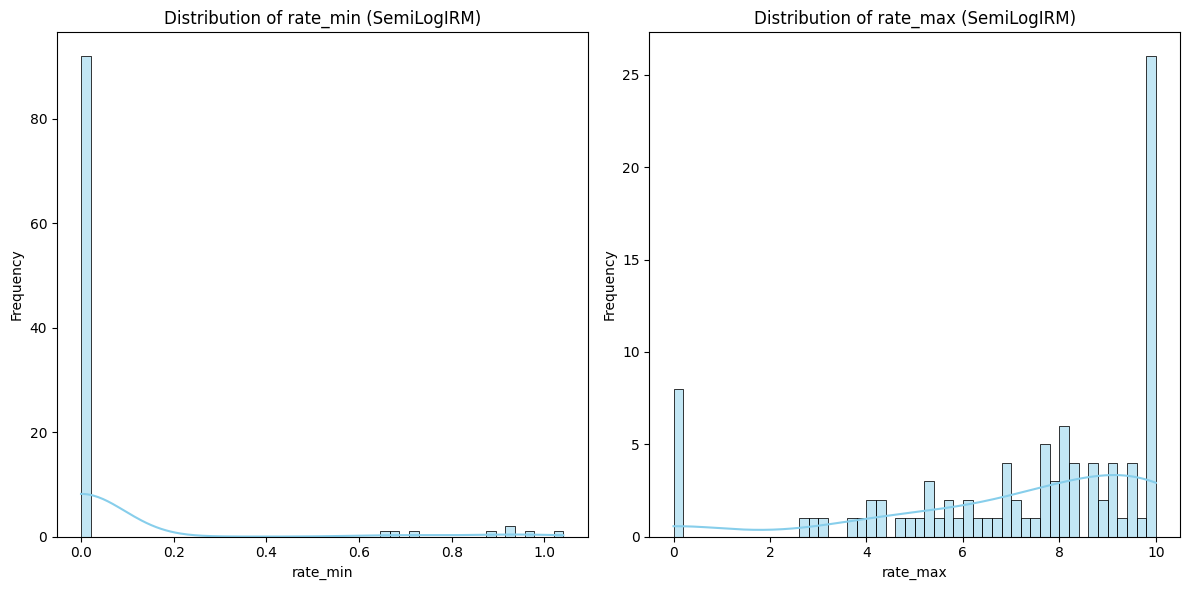

In [97]:
# Plotting
plt.figure(figsize=(12, 6))
for idx, param in enumerate(['rate_min', 'rate_max']):
    plt.subplot(1, 2, idx+1)
    sns.histplot(semilog_optimal_rerun_df[param], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {param} (SemiLogIRM)')
    plt.xlabel(param)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


##### Differential Evolution

In [132]:
import pandas as pd
import numpy as np
from typing import Tuple, Type, List

def update_semilog(irm, rate_min, rate_max):
    
    # Update IRM parameters
    irm.rate_min = rate_min
    irm.rate_max = rate_max

def optimal_parameter_stability_de(
    df: pd.DataFrame,
    irm_class: Type,
    bounds: List[Tuple[float, float]],
    update_params_func: callable,
    re_runs: int = 100,
    max_iter: int = 30,
    popsize: int = 15,
    random_state: int = 42,
    **opt_kwargs
) -> pd.DataFrame:
    """
    Assess parameter stability for any IRM using Differential Evolution.

    Parameters:
    - df: Original DataFrame used for calibration.
    - irm_class: IRM class to optimize.
    - bounds: List of tuples defining the parameter bounds for rate_min and rate_max.
    - update_params_func: Callable to update IRM parameters (specific to model).
    - re_runs: Number of bootstrap samples (repeated runs).
    - max_iter: Maximum number of iterations for Differential Evolution.
    - popsize: Population size for Differential Evolution.
    - random_state: Seed for reproducibility.
    - opt_kwargs: Additional keyword arguments for the optimization function.

    Returns:
    - bootstrap_df: DataFrame containing parameter estimates for each bootstrap.
    """
    np.random.seed(random_state)
    params_dict = {}

    for i in range(re_runs):
        print(f"Re-run {i+1}/{re_runs}")

        # Call the differential_evolution_optimizer function
        result_de = differential_evolution_optimizer(
            df=df,
            irm_class=irm_class,
            bounds=bounds,
            update_params=update_params_func,
            target_u=opt_kwargs.get('target_u', 0.9),
            threshold_u=opt_kwargs.get('threshold_u', 0.95),
            num_steps=opt_kwargs.get('num_steps', 180),
            num_paths=opt_kwargs.get('num_paths', 100),
            weights=opt_kwargs.get('weights', {'MSE': 1.0, 'Time_Above_Threshold': 1, 'Volatility_U': 1}),
            max_iter=max_iter,
            popsize=popsize,
            model_input=opt_kwargs.get('model_input'),
            seed=random_state + i
        )

        # Store the optimized parameters
        params_dict[i] = result_de.x

    # Convert to DataFrame
    df_r = pd.DataFrame(params_dict)
    df_r = df_r.T
    df_r.columns = ['rate_min', 'rate_max']
    return df_r


In [145]:
# Define bounds for rate_min and rate_max
bounds = [(0.0001, 10), (0.0001, 10)]

# Call the function
bootstrap_results = optimal_parameter_stability_de(
    df=df,
    irm_class=SemiLogIRM,
    bounds=bounds,
    update_params_func=update_semilog,
    re_runs=50,  # Number of re-runs
    max_iter=100,
    popsize=15,
    random_state=42,
    model_input=parameters  # Example model inputs
)

Re-run 1/50
Optimized parameters: [0.01520274 0.60113654]
Re-run 2/50
Optimized parameters: [1.99666721e-04 6.24003472e+00]
Re-run 3/50
Optimized parameters: [0.0037086  1.51756556]
Re-run 4/50
Optimized parameters: [5.36677969e-04 4.75260181e+00]
Re-run 5/50
Optimized parameters: [2.15386991e-04 5.37244512e+00]
Re-run 6/50
Optimized parameters: [4.65993628e-04 4.63196652e+00]
Re-run 7/50
Optimized parameters: [1.78456576e-04 3.34419277e+00]
Re-run 8/50
Optimized parameters: [1.12209456e-03 1.71033017e+00]
Re-run 9/50
Optimized parameters: [1.43306299e-04 8.39531674e+00]
Re-run 10/50
Optimized parameters: [1.03169804e-04 2.49703381e+00]
Re-run 11/50
Optimized parameters: [0.0052131  1.14262199]
Re-run 12/50
Optimized parameters: [2.11638649e-04 3.70773425e+00]
Re-run 13/50
Optimized parameters: [0.11172045 0.30013201]
Re-run 14/50
Optimized parameters: [5.56744633e-04 4.45211979e+00]
Re-run 15/50
Optimized parameters: [5.46130091e-04 5.62849840e+00]
Re-run 16/50
Optimized parameters: [

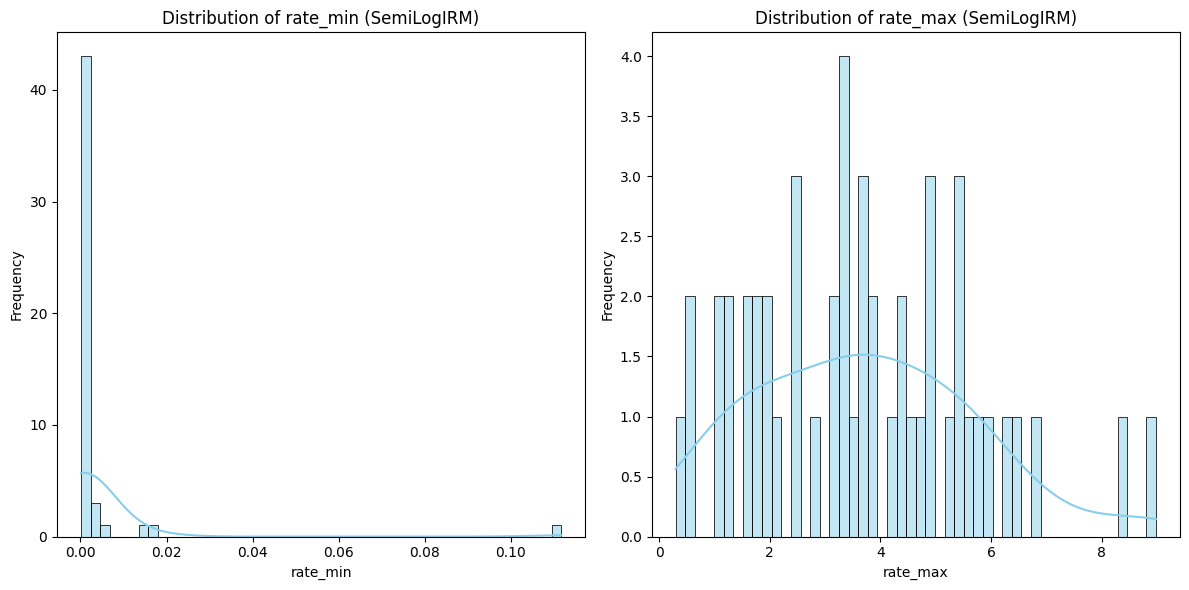

In [146]:
# Plotting
plt.figure(figsize=(12, 6))
for idx, param in enumerate(['rate_min', 'rate_max']):
    plt.subplot(1, 2, idx+1)
    sns.histplot(bootstrap_results[param], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {param} (SemiLogIRM)')
    plt.xlabel(param)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



##### CMA-ES

In [ ]:
from src.optimization import cmaes_optimizer
# Define bounds for rate_min and rate_max
bounds = [(0.0001, 10), (0.0001, 10)]

def update_semilog(irm, rate_min, rate_max):
    
    # Update IRM parameters
    irm.rate_min = rate_min
    irm.rate_max = rate_max

# Run CMA-ES optimizer
result_cames = cmaes_optimizer(
    df=df,
    irm_class=SemiLogIRM,
    update_params=update_semilog,
    bounds=bounds,
    target_u=0.9,
    threshold_u=0.95,
    num_steps=180,
    num_paths=100,
    weights={'MSE': 1.0, 'Time_Above_Threshold': 1.0, 'Volatility_U': 1.0},
    max_iter=100,
    sigma=1,
    random_state=42,
    model_input=parameters
)

print("Best Parameters:", result_cames.result.xbest)
print("Best Objective Value:", result_cames.result.fbest)


(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=42, Mon Dec 16 20:17:58 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 6.622001185945359e-01 1.0e+00 3.94e-01  3e-01  4e-01 0:00.4
    2     12 6.614636677249693e-01 1.3e+00 4.39e-01  4e-01  5e-01 0:00.7
    3     18 6.462409097246523e-01 1.8e+00 4.69e-01  4e-01  5e-01 0:01.6
    6     36 5.600245909607057e-01 1.7e+00 7.66e-01  7e-01  8e-01 0:05.0
    9     54 2.449542760294297e-01 1.8e+00 1.89e+00  1e+00  2e+00 0:09.2
   13     78 3.111865234673299e-01 1.3e+00 1.64e+00  7e-01  1e+00 0:15.5
   17    102 2.723562901288760e-01 2.2e+00 1.06e+00  4e-01  4e-01 0:21.8
   22    132 2.331628275521802e-01 3.3e+00 5.77e-01  1e-01  2e-01 0:29.4
   28    168 2.270095790512283e-01 8.9e+00 3.85e-01  3e-02  2e-01 0:38.6
   34    204 2.271918619844184e-01 1.6e+01 2.48e-01  9e-03  9e-02 0:48.8
   40    240 2.230368546938318e-01 1.9e+01 1.15e-01  3e-03  3e-02 0:59.5
   47    282 2.234602736581017e-01 3.9e

In [150]:
import pandas as pd
import numpy as np
from typing import Tuple, Type, List

def optimal_parameter_stability_cmaes(
    df: pd.DataFrame,
    irm_class: Type,
    bounds: List[Tuple[float, float]],
    update_params_func: callable,
    re_runs: int = 100,
    max_iter: int = 100,
    sigma: float = 0.5,
    random_state: int = 42,
    **opt_kwargs
) -> pd.DataFrame:
    """
    Assess parameter stability for any IRM using CMA-ES.

    Parameters:
    - df: Original DataFrame used for calibration.
    - irm_class: IRM class to optimize.
    - bounds: List of tuples defining the parameter bounds for rate_min and rate_max.
    - update_params_func: Callable to update IRM parameters (specific to model).
    - re_runs: Number of bootstrap samples (repeated runs).
    - max_iter: Maximum number of CMA-ES iterations.
    - sigma: Initial step size for CMA-ES.
    - random_state: Seed for reproducibility.
    - opt_kwargs: Additional keyword arguments for the optimization function.

    Returns:
    - bootstrap_df: DataFrame containing parameter estimates for each bootstrap.
    """
    np.random.seed(random_state)
    params_dict = {}

    for i in range(re_runs):
        print(f"Re-run {i+1}/{re_runs}")

        # Call the cmaes_optimizer function
        result_cames = cmaes_optimizer(
            df=df,
            irm_class=irm_class,
            update_params=update_params_func,
            bounds=bounds,
            target_u=opt_kwargs.get('target_u', 0.9),
            threshold_u=opt_kwargs.get('threshold_u', 0.95),
            num_steps=opt_kwargs.get('num_steps', 180),
            num_paths=opt_kwargs.get('num_paths', 100),
            weights=opt_kwargs.get('weights', {'MSE': 1.0, 'Time_Above_Threshold': 1, 'Volatility_U': 1}),
            max_iter=max_iter,
            sigma=sigma,
            random_state=random_state + i,
            model_input=opt_kwargs.get('model_input', (1, 1, 1, 1))
        )

        # Store the optimized parameters
        params_dict[i] = result_cames.result.xbest

    # Convert to DataFrame
    df_r = pd.DataFrame(params_dict)
    df_r = df_r.T
    df_r.columns = ['rate_min', 'rate_max']
    return df_r


In [151]:
# Define bounds for rate_min and rate_max
bounds = [(0.0001, 10), (0.0001, 10)]

# Run the stability test
bootstrap_results_cames = optimal_parameter_stability_cmaes(
    df=df,
    irm_class=SemiLogIRM,
    bounds=bounds,
    update_params_func=update_semilog,
    re_runs=50,  # Number of re-runs
    max_iter=100,
    sigma=0.5,
    random_state=42,
    model_input=parameters  # Example model inputs
)


Re-run 1/50
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=42, Mon Dec 16 19:32:07 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 6.640719604186374e-01 1.0e+00 4.20e-01  4e-01  4e-01 0:00.2
    2     12 6.401006813668287e-01 1.3e+00 4.38e-01  3e-01  4e-01 0:00.4
    3     18 5.929689821740325e-01 1.4e+00 6.99e-01  6e-01  7e-01 0:00.7
   12     72 2.623743104415250e-01 1.4e+00 9.66e-01  5e-01  6e-01 0:03.9
   24    144 2.291678058788617e-01 7.2e+00 5.23e-01  4e-02  4e-01 0:08.1
   38    228 2.118584270176986e-01 3.8e+01 1.90e-01  6e-03  1e-01 0:13.2
   57    342 2.194906745724208e-01 1.2e+01 4.81e-01  1e-02  1e-01 0:19.4
   77    462 2.166487406025339e-01 3.0e+01 1.78e-01  1e-03  4e-02 0:26.4
  100    600 2.159602491045553e-01 1.6e+02 1.15e-01  1e-03  3e-02 0:33.9
Optimized parameters: [1.16072634e-04 5.05480751e+00], Objective value: 0.2118584270176986
Re-run 2/50
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=43, Mon Dec 16

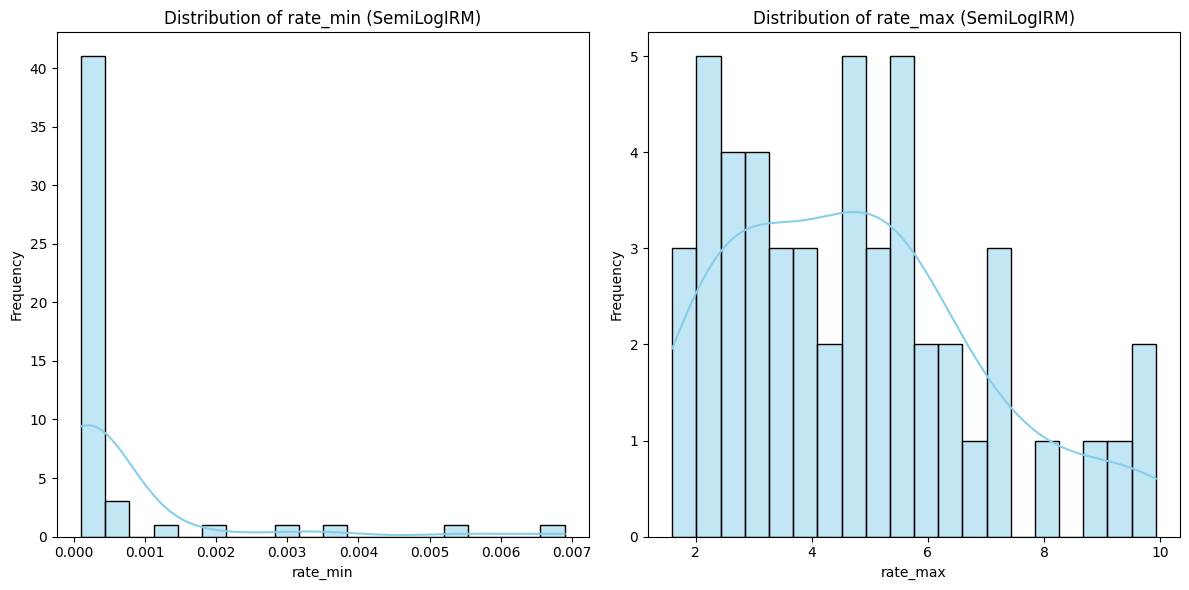

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
for idx, param in enumerate(['rate_min', 'rate_max']):
    plt.subplot(1, 2, idx+1)
    sns.histplot(bootstrap_results_cames[param], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribution of {param} (SemiLogIRM)')
    plt.xlabel(param)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



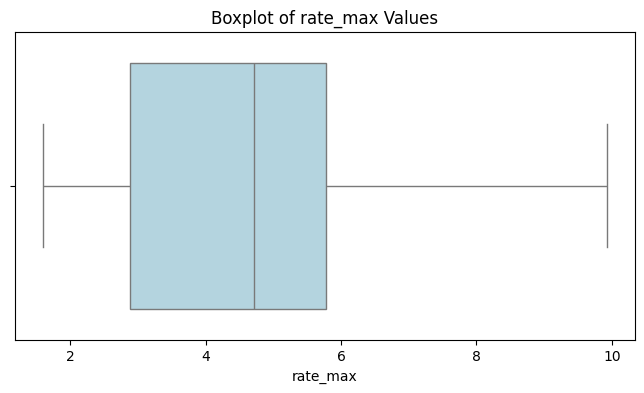

In [164]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=bootstrap_results_cames['rate_max'], color='lightblue')
plt.title("Boxplot of rate_max Values")
plt.xlabel("rate_max")
plt.show()


### Linear Piece wise function

In [104]:
from src.interest_rate_models.piecewise_linear_irm import PieceWiseLinearIRM
# def update_piecewise_params(irm, r0=None, r1=None, r2=None, u_opt=None):
#     """
#     Update parameters for PieceWiseLinearIRM while ensuring constraints.
    
#     Constraints:
#     - r0, r1, r2 > 0
#     - 0 < u_opt < 1
#     """
#     if r0 is None or r1 is None or r2 is None or u_opt is None:
#         raise ValueError("All parameters (r0, r1, r2, u_opt) must be provided.")
    
#     if not (0 < u_opt < 1):
#         raise ValueError("u_opt must be between 0 and 1.")
    
#     if r0 <= 0 or r1 <= 0 or r2 <= 0:
#         raise ValueError("r0, r1, and r2 must be greater than 0.")
    
#     irm.r0 = r0
#     irm.r1 = r1
#     irm.r2 = r2
#     irm.u_opt = u_opt

def update_piecewise_params(irm, r0=None, r2=None, fraction=None, u_opt=None):
    """
    Update parameters for PieceWiseLinearIRM while ensuring constraints.
    
    Constraints:
    - delta_r1 = fraction * r2
    - r1 = r2 - delta_r1, ensuring r1 < r2 and r1 > 0
    - fraction ∈ [0, 1)
    """
    if r0 is None or r2 is None or fraction is None or u_opt is None:
        raise ValueError("All parameters (r0, r2, fraction, u_opt) must be provided.")
    
    if r0 <= 0 or r2 <= 0 :#or fraction < 0 or fraction >= 1:
        raise ValueError("r0 and r2 must be > 0, and fraction must be in [0, 1).")
    
    # delta_r1 = fraction * r2
    # r1 = r2 - delta_r1

    r1 = fraction * r2
    
    irm.r0 = r0
    irm.r1 = r1
    irm.r2 = r2
    irm.u_opt = 0.9  # Use fixed or optimized value


optimial_params_pwl = optimize_irm_parameters(
    df=df_last6,
    irm_class=PieceWiseLinearIRM,
    search_space = [
        Real(0.0001, 0.15, name='r0'),        # Base rate
        Real(0.01, 1.0, name='r2'),            # Larger slope
        Real(0.01, 0.5, name='fraction'),    # Fraction for delta_r1
        Real(0.5, 0.95, name='u_opt')        # Optimal utilization (can be fixed)
    ],
    update_params=update_piecewise_params,
    target_u=0.9,
    threshold_u=0.95,
    num_steps=180,
    num_paths=100,
    weights={'MSE': 1.0, 'Time_Above_Threshold': 0.5, 'Volatility_U': 0.5},
    n_calls=30,
    model_input=parameters,
    random_state=42
)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1020
Function value obtained: 0.1752
Current minimum: 0.1752
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0513
Function value obtained: 0.2283
Current minimum: 0.1752
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0502
Function value obtained: 0.2881
Current minimum: 0.1752
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0590
Function value obtained: 0.1719
Current minimum: 0.1719
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0626
Function value obtained: 0.3174
Current minimum: 0.1719
Iteration No: 6 started. Evaluating

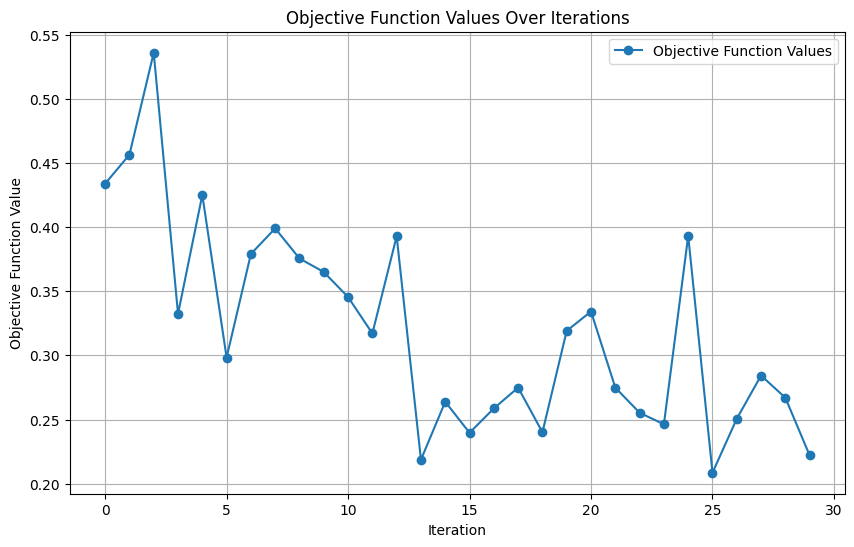

In [101]:

# Assuming optimal_params_semilog.func_vals contains the function values
plt.figure(figsize=(10, 6))
plt.plot(optimial_params_pwl.func_vals, marker='o', linestyle='-', label='Objective Function Values')
plt.title('Objective Function Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.legend()
plt.grid(True)
plt.show()



Optimized IRM Metrics Summary:
               MSE  Time_Above_Threshold  Volatility_U
count  5000.000000           5000.000000   5000.000000
mean      0.116329              0.037000      0.140489
std       0.036843              0.380605      0.023049
min       0.021622              0.000000      0.078817
25%       0.089845              0.000000      0.124454
50%       0.113557              0.000000      0.139096
75%       0.139366              0.000000      0.154453
max       0.308921             10.000000      0.255569


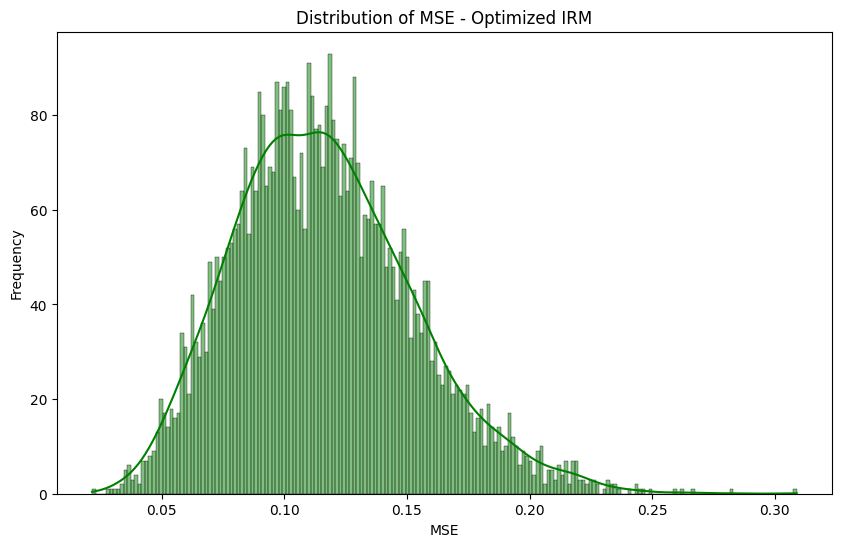

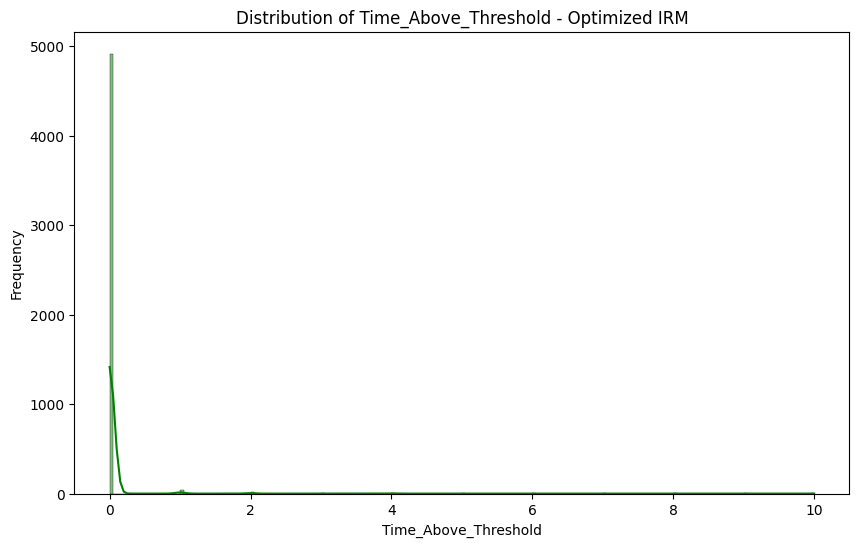

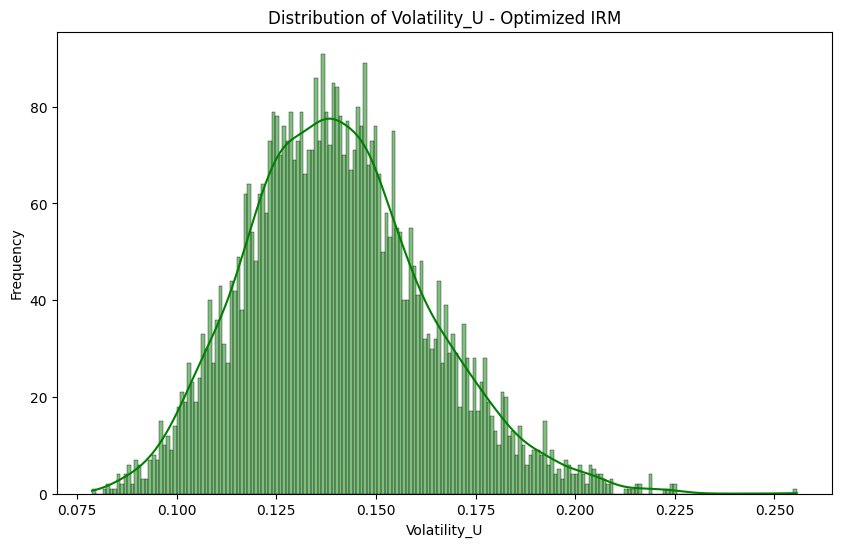

In [103]:
import seaborn as sns
metrics_df = validate_optimized_irm(
    optimized_params=optimial_params_pwl.x,
    df=df_last6,
    alpha=alpha,
    rho=rho,
    b1=b1,
    sigma=sigma,
    irm_class=PieceWiseLinearIRM,
    num_steps=180,
    num_paths=5000,
    target_u=0.9,
    threshold_u=0.95
)

# Summary Statistics
print("\nOptimized IRM Metrics Summary:")
print(metrics_df.describe())

# Visualizations
metrics_to_plot = ['MSE', 'Time_Above_Threshold', 'Volatility_U']
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(metrics_df[metric], bins=200, kde=True, color='green')
    plt.title(f'Distribution of {metric} - Optimized IRM')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()


Optimized IRM Metrics Summary:
                r0           r1           r2        u_opt          MSE  \
count  6750.000000  6750.000000  6750.000000  6750.000000  6750.000000   
mean      0.235000     0.403333     1.220000     0.700000     0.106108   
std       0.143625     0.281604     0.477808     0.129109     0.017679   
min       0.010000     0.010000     0.100000     0.500000     0.065717   
25%       0.110000     0.110000     0.900000     0.600000     0.093051   
50%       0.235000     0.410000     1.300000     0.700000     0.105694   
75%       0.360000     0.610000     1.700000     0.800000     0.118147   
max       0.460000     0.910000     1.900000     0.900000     0.161660   

       Time_Above_Threshold  Volatility_U  
count           6750.000000   6750.000000  
mean               0.246679      0.150102  
std                0.237626      0.003821  
min                0.000000      0.135955  
25%                0.080000      0.147531  
50%                0.170000      0.15

<Figure size 1200x800 with 0 Axes>

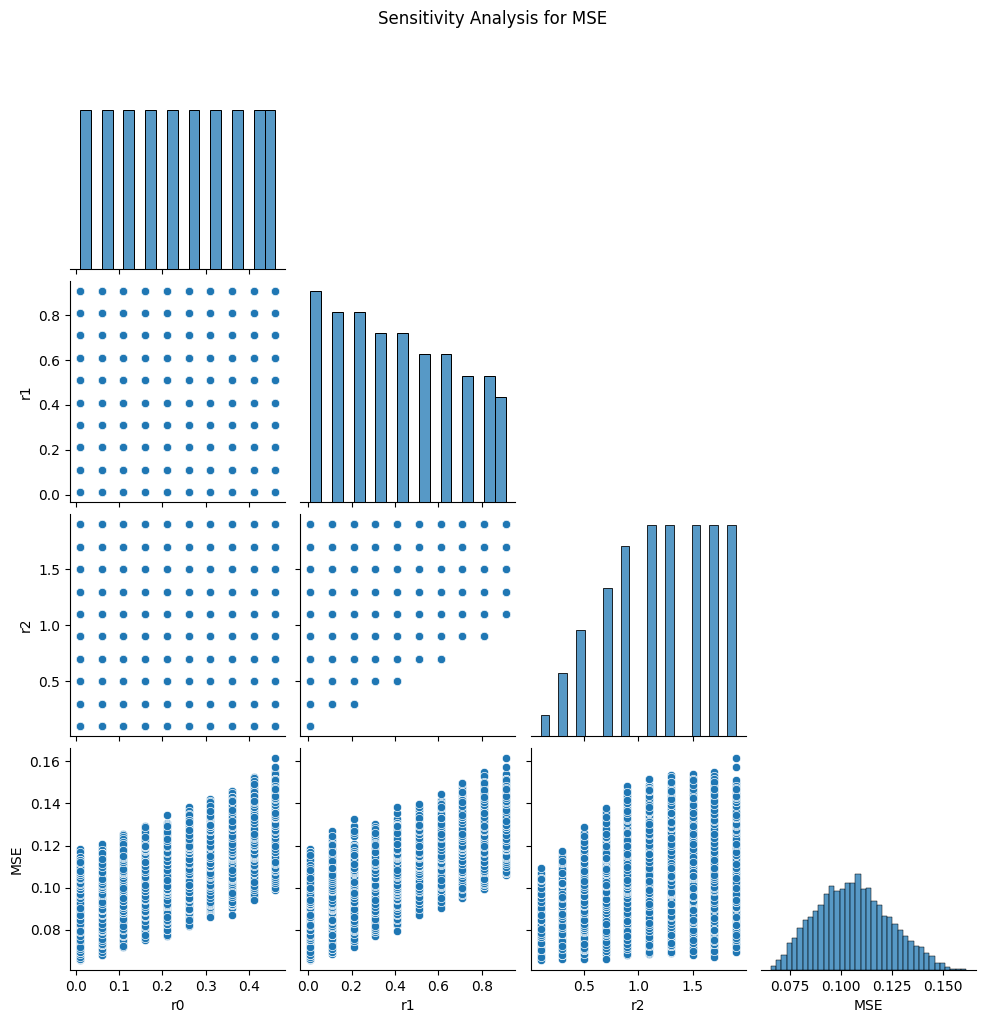

<Figure size 1200x800 with 0 Axes>

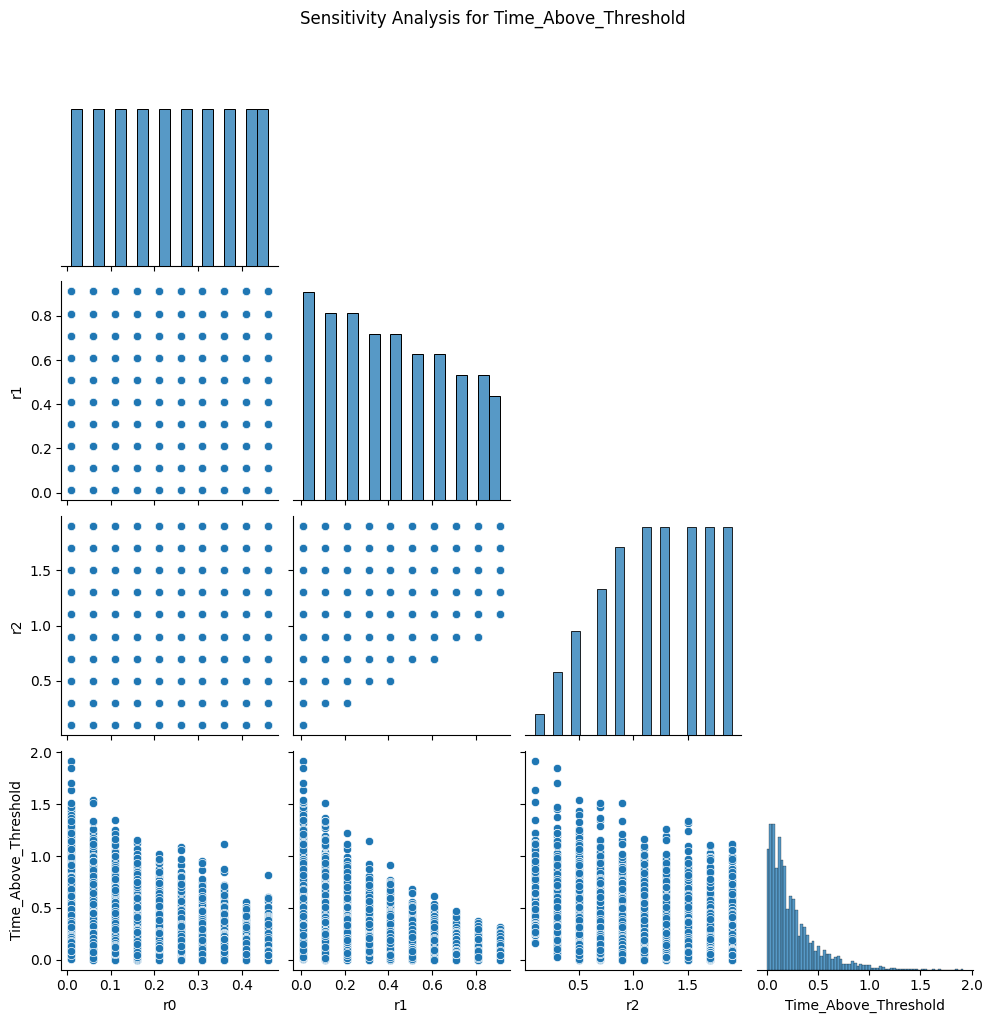

<Figure size 1200x800 with 0 Axes>

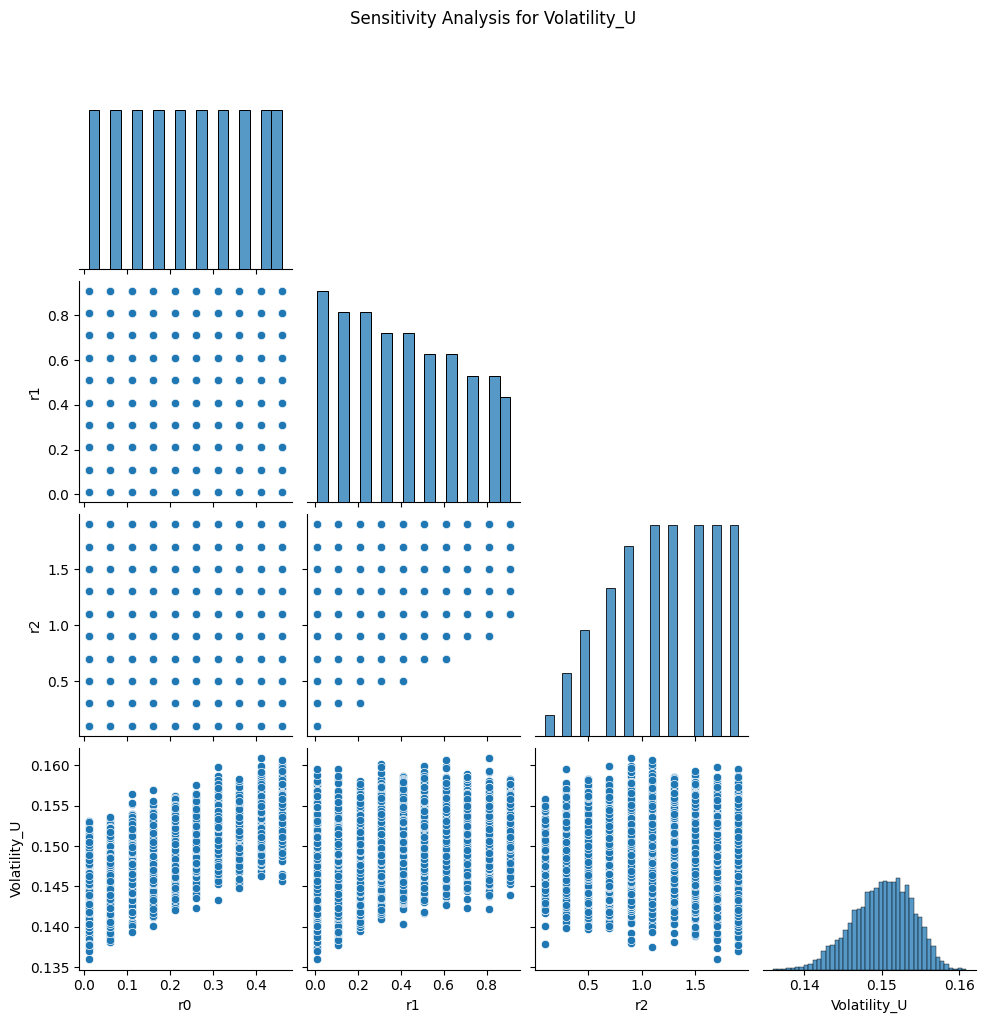

In [90]:
def sensitivity_analysis_piecewise_irm(r0_range, r1_range, r2_range, u_opt_range, df, alpha, rho, b1, sigma, irm_class, num_steps, num_paths, target_u, threshold_u):
    """
    Conduct a sensitivity analysis for PieceWiseLinearIRM parameters.

    Parameters:
    - r0_range: Tuple (min, max, step) for r0 (base rate)
    - r1_range: Tuple (min, max, step) for r1 (slope for u ≤ u_opt)
    - r2_range: Tuple (min, max, step) for r2 (slope for u > u_opt)
    - u_opt_range: Tuple (min, max, step) for u_opt (optimal utilization)
    - df: DataFrame with calibrated parameters
    - alpha, rho, b1, sigma: W model parameters
    - irm_class: IRM class to evaluate
    - num_steps: Number of simulation steps
    - num_paths: Number of simulation paths
    - target_u: Target utilization ratio
    - threshold_u: Threshold utilization ratio

    Returns:
    - metrics_df: DataFrame with evaluation metrics for each parameter combination
    """
    r0_values = np.arange(*r0_range)
    r1_values = np.arange(*r1_range)
    r2_values = np.arange(*r2_range)
    u_opt_values = np.arange(*u_opt_range)
    metrics_data = []

    for r0 in r0_values:
        for r1 in r1_values:
            for r2 in r2_values:
                for u_opt in u_opt_values:
                    if r1 >= r2 or u_opt <= 0 or u_opt >= 1:
                        continue  # Skip invalid combinations
                    
                    irm = irm_class(r0=r0, r1=r1, r2=r2, u_opt=u_opt)
                    sim_results = simulate_utilization_paths(
                        alpha=alpha,
                        rho=rho,
                        b1=b1,
                        sigma=sigma,
                        W0=df['W'].iloc[-1],
                        num_steps=num_steps,
                        num_paths=num_paths,
                        controller_type=irm
                    )

                    # Calculate metrics
                    mse_total = 0.0
                    time_above_threshold_total = 0.0
                    vol_u_total = 0.0

                    for path in sim_results:
                        metrics = calculate_metrics(path, target_u, threshold_u)
                        mse_total += metrics['MSE']
                        time_above_threshold_total += metrics['Time_Above_Threshold']
                        vol_u_total += metrics['Volatility_U']

                    avg_metrics = {
                        'r0': r0,
                        'r1': r1,
                        'r2': r2,
                        'u_opt': u_opt,
                        'MSE': mse_total / num_paths,
                        'Time_Above_Threshold': time_above_threshold_total / num_paths,
                        'Volatility_U': vol_u_total / num_paths,
                    }
                    metrics_data.append(avg_metrics)

    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df


# Define ranges for r0, r1, r2, and u_opt
r0_range = (0.01, 0.5, 0.05)        # 0.01 to 0.5 with step size 0.05
r1_range = (0.01, 1.0, 0.1)         # 0.01 to 1.0 with step size 0.1
r2_range = (0.1, 2.0, 0.2)          # 0.1 to 2.0 with step size 0.2
u_opt_range = (0.5, 0.95, 0.05)     # 0.5 to 0.95 with step size 0.05

# Conduct sensitivity analysis for PieceWiseLinearIRM
metrics_df = sensitivity_analysis_piecewise_irm(
    r0_range=r0_range,
    r1_range=r1_range,
    r2_range=r2_range,
    u_opt_range=u_opt_range,
    df=df_last6,
    alpha=alpha,
    rho=rho,
    b1=b1,
    sigma=sigma,
    irm_class=PieceWiseLinearIRM,
    num_steps=365,
    num_paths=100,
    target_u=0.9,
    threshold_u=0.95
)

# Summary Statistics
print("\nOptimized IRM Metrics Summary:")
print(metrics_df.describe())

# Visualizations: Grid Chart for Metrics
metrics_to_plot = ['MSE', 'Time_Above_Threshold', 'Volatility_U']
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 8))
    sns.pairplot(metrics_df, vars=['r0', 'r1', 'r2', metric], corner=True)
    plt.suptitle(f'Sensitivity Analysis for {metric}', y=1.02)
    plt.show()




Optimized IRM Metrics Summary:
               MSE  Time_Above_Threshold  Volatility_U
count  5000.000000           5000.000000   5000.000000
mean      0.112980              0.055200      0.144040
std       0.036813              0.496188      0.024239
min       0.021639              0.000000      0.072229
25%       0.087306              0.000000      0.126415
50%       0.109280              0.000000      0.141824
75%       0.136367              0.000000      0.159968
max       0.263733             11.000000      0.246056


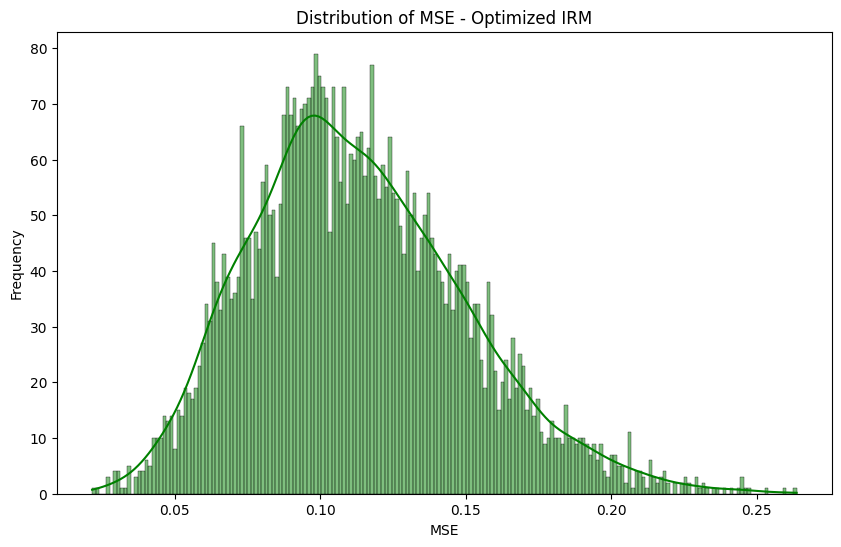

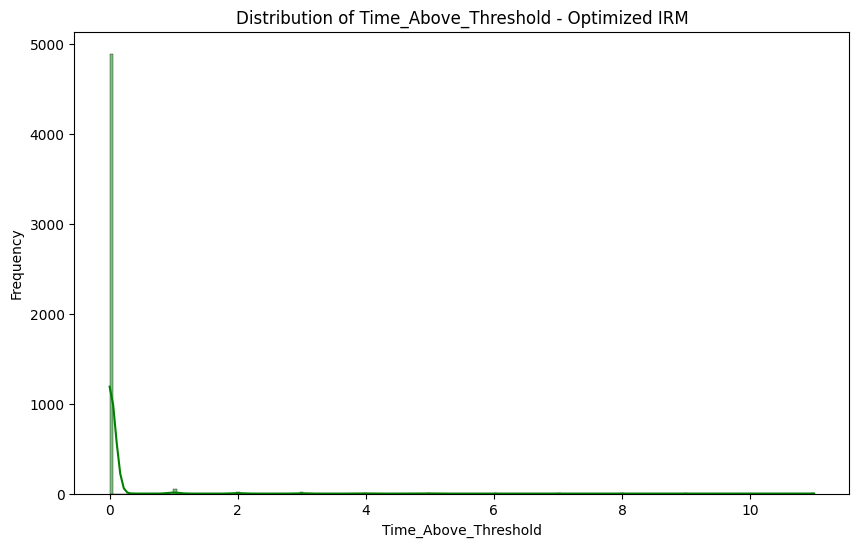

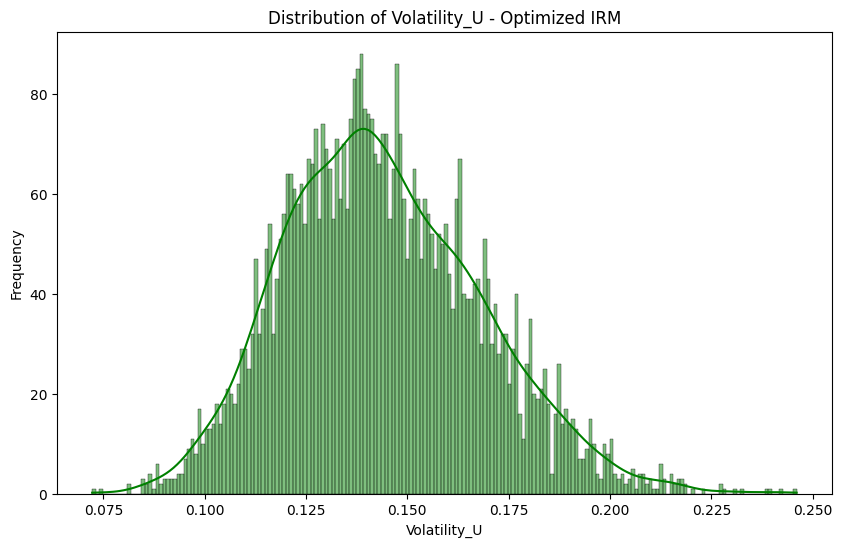

In [ ]:
import seaborn as sns
metrics_df = validate_optimized_irm(
    optimized_params=optimial_params_pwl,
    df=df_last6,
    alpha=alpha,
    rho=rho,
    b1=b1,
    sigma=sigma,
    irm_class=PieceWiseLinearIRM,
    num_steps=180,
    num_paths=5000,
    target_u=0.9,
    threshold_u=0.95
)

# Summary Statistics
print("\nOptimized IRM Metrics Summary:")
print(metrics_df.describe())

# Visualizations
metrics_to_plot = ['MSE', 'Time_Above_Threshold', 'Volatility_U']
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(metrics_df[metric], bins=200, kde=True, color='green')
    plt.title(f'Distribution of {metric} - Optimized IRM')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.show()

### Comparision of optimal PieceWiseLinearIRM and SemiLogIRM

In [118]:
# Assuming validate_optimized_irm returns a DataFrame with metrics for a given model

# optimal_params_semilog = (0.0001, 34.93386147230743)
# optimial_params_pwl = (0.5, 0.1,1.0, 0.9)
metrics_piecewise = validate_optimized_irm(
    optimized_params=optimial_params_pwl_2,
    df=df_last6,
    alpha=alpha,
    rho=rho,
    b1=b1,
    sigma=sigma,
    irm_class=PieceWiseLinearIRM,
    num_steps=180,
    num_paths=5000,
    target_u=0.9,
    threshold_u=0.95
)

metrics_semilog = validate_optimized_irm(
    optimized_params=optimal_params_semilog,
    df=df_last6,
    alpha=alpha,
    rho=rho,
    b1=b1,
    sigma=sigma,
    irm_class=SemiLogIRM,
    num_steps=180,
    num_paths=5000,
    target_u=0.9,
    threshold_u=0.95
)

# Add a column to identify the model
metrics_piecewise['Model'] = 'PieceWiseLinearIRM'
metrics_semilog['Model'] = 'SemiLogIRM'

# Combine both metrics
combined_metrics = pd.concat([metrics_piecewise, metrics_semilog], ignore_index=True)


/tmp/ipykernel_8990/1784949586.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_metrics, x='Model', y=metric, palette='Set2')


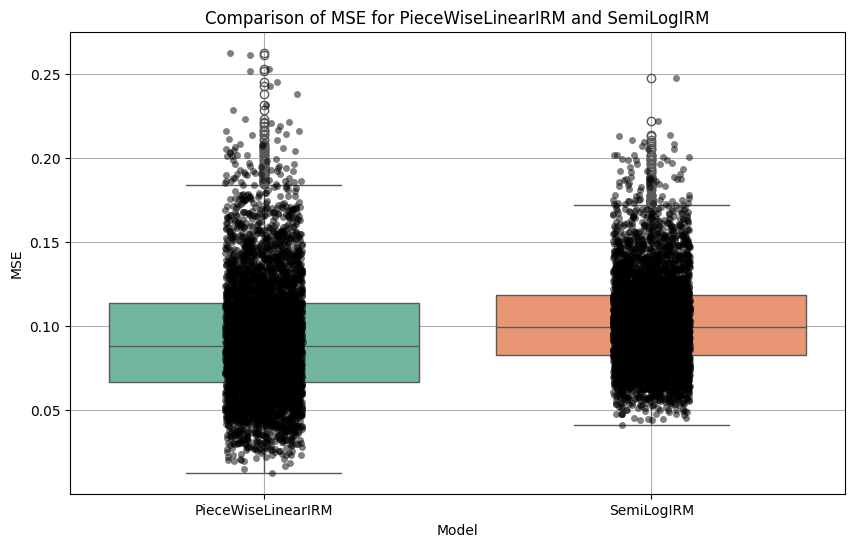

/tmp/ipykernel_8990/1784949586.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_metrics, x='Model', y=metric, palette='Set2')


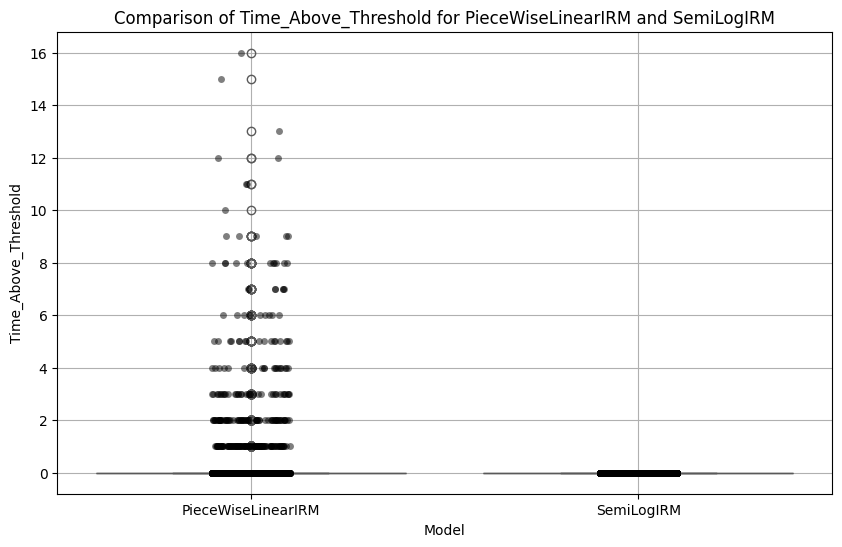

/tmp/ipykernel_8990/1784949586.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_metrics, x='Model', y=metric, palette='Set2')


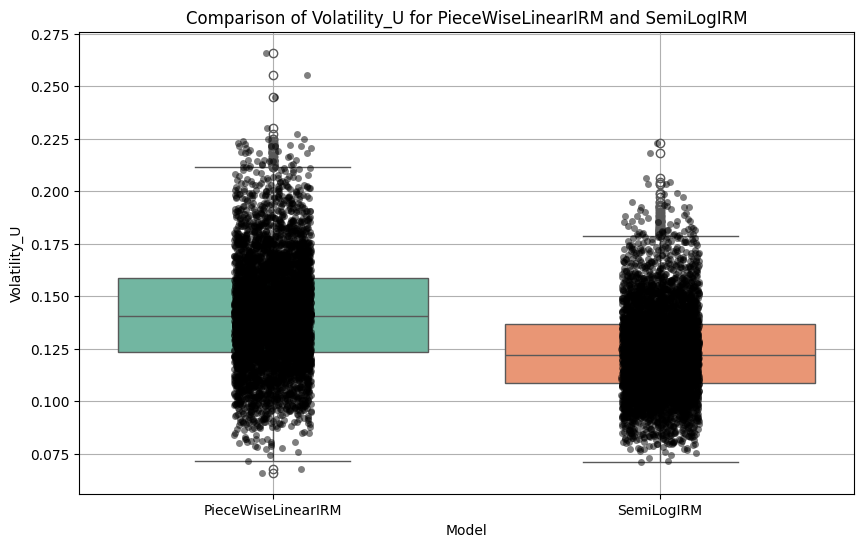

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics_to_plot = ['MSE', 'Time_Above_Threshold', 'Volatility_U']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_metrics, x='Model', y=metric, palette='Set2')
    sns.stripplot(data=combined_metrics, x='Model', y=metric, color='black', alpha=0.5, jitter=True)
    plt.title(f'Comparison of {metric} for PieceWiseLinearIRM and SemiLogIRM')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.grid()
    plt.show()


In [120]:
from scipy.stats import ttest_ind, mannwhitneyu

# Perform tests for each metric
for metric in metrics_to_plot:
    data_piecewise = metrics_piecewise[metric]
    data_semilog = metrics_semilog[metric]

    # T-test
    t_stat, p_value = ttest_ind(data_piecewise, data_semilog, equal_var=False)

    # Mann-Whitney U test
    u_stat, p_u_value = mannwhitneyu(data_piecewise, data_semilog, alternative='two-sided')

    print(f"\nMetric: {metric}")
    print(f"T-Test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Mann-Whitney U Test: u-statistic = {u_stat:.4f}, p-value = {p_u_value:.4f}")

    # Interpretation of results
    if p_value < 0.05:
        print("T-Test: Significant difference between the models for this metric.")
    else:
        print("T-Test: No significant difference between the models for this metric.")

    if p_u_value < 0.05:
        print("Mann-Whitney U Test: Significant difference between the models for this metric.")
    else:
        print("Mann-Whitney U Test: No significant difference between the models for this metric.")



Metric: MSE
T-Test: t-statistic = -15.5961, p-value = 0.0000
Mann-Whitney U Test: u-statistic = 9948566.0000, p-value = 0.0000
T-Test: Significant difference between the models for this metric.
Mann-Whitney U Test: Significant difference between the models for this metric.

Metric: Time_Above_Threshold
T-Test: t-statistic = 12.8712, p-value = 0.0000
Mann-Whitney U Test: u-statistic = 13215000.0000, p-value = 0.0000
T-Test: Significant difference between the models for this metric.
Mann-Whitney U Test: Significant difference between the models for this metric.

Metric: Volatility_U
T-Test: t-statistic = 38.6091, p-value = 0.0000
Mann-Whitney U Test: u-statistic = 17682249.0000, p-value = 0.0000
T-Test: Significant difference between the models for this metric.
Mann-Whitney U Test: Significant difference between the models for this metric.


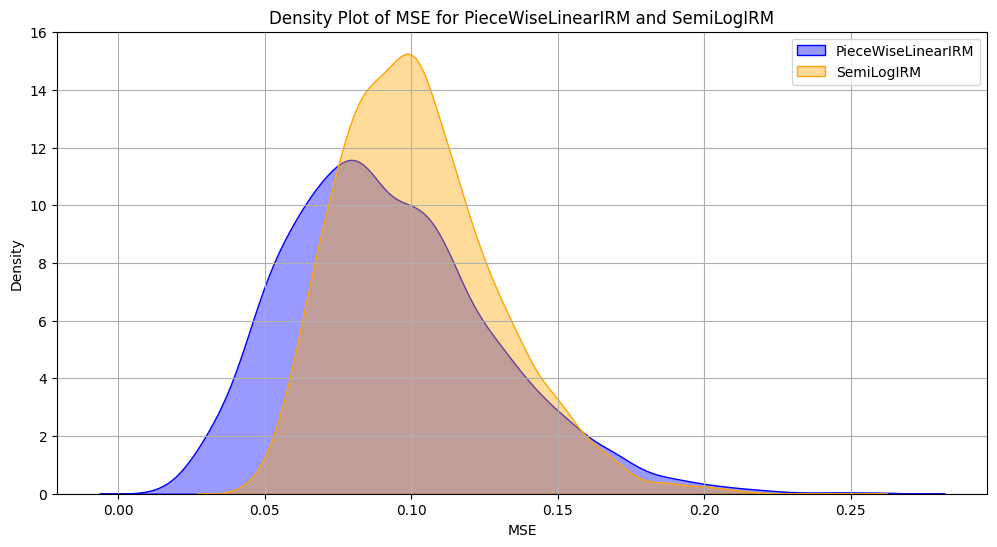

/tmp/ipykernel_8990/3275523212.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


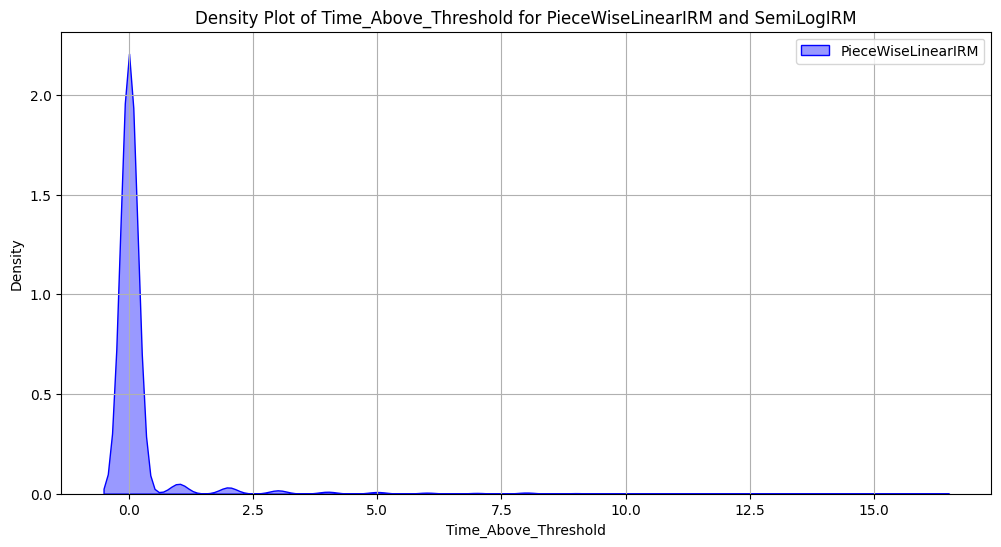

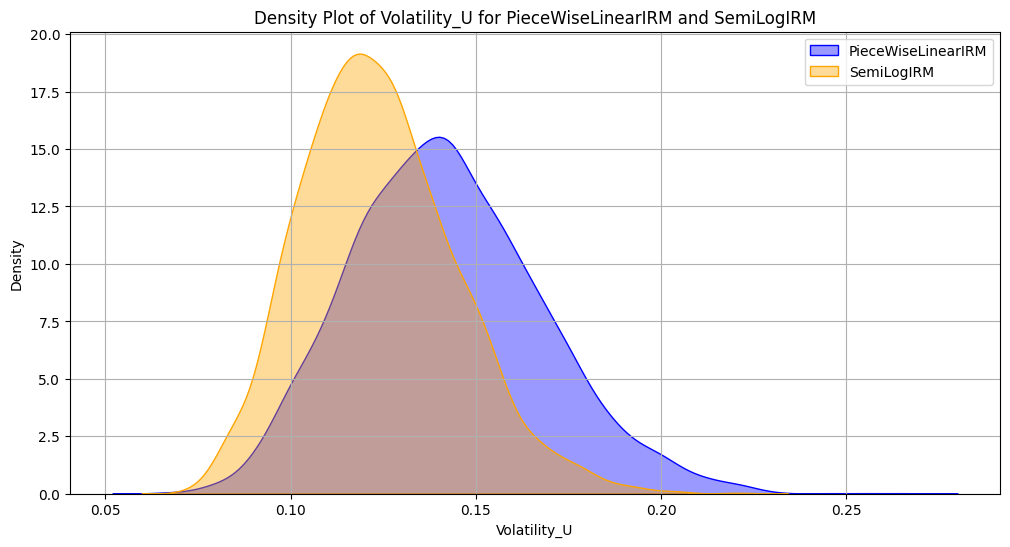

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics to compare
metrics_to_plot = ['MSE', 'Time_Above_Threshold', 'Volatility_U']

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(
        data=metrics_piecewise[metric],
        label='PieceWiseLinearIRM',
        fill=True,
        alpha=0.4,
        color='blue'
    )
    sns.kdeplot(
        data=metrics_semilog[metric],
        label='SemiLogIRM',
        fill=True,
        alpha=0.4,
        color='orange'
    )
    plt.title(f'Density Plot of {metric} for PieceWiseLinearIRM and SemiLogIRM')
    plt.xlabel(metric)
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()
